# Imports  

In [1]:
from gliderad2cp import process_adcp

# Section 1: calculate velocity shear

## 1.1 Begin ADCP Data Processing

Set paths to input files and specify options

In [2]:
import pooch

server = "https://zenodo.org/records/10082274/files/"
mission = "sea057_M43"
data_source = pooch.create(
    path=pooch.os_cache("gliderad2cp"),
    base_url=server,
    registry={
        "sea057_M43.ad2cp.00000_1.nc": "sha256:775055eff485476af1cf79462e6ae400df04608bc1263434ea9a393e556d7b72",
        "sea057_M43.ad2cp.00000_2.nc": "sha256:71738df881c6a3d770b9c87f2d0607be979b1a75f2fa254c13720195b0cfa97e",
        "SEA057_M43.pqt": "2e72eda509d1c7027c9ed5ec70266b9bb161203e085c3de780aa9ee8ccb9cbce",
    },
)

In [3]:
for filename in data_source.registry_files:
    data_source.fetch(filename)

In [4]:
glider_pqt_path = data_source.path / 'SEA057_M43.pqt'
adcp_path = f"{data_source.path}/sea057_M43*.nc"

options = {
    'debug_plots' : True,
    'correctADCPHeading' : True,
    'ADCP_discardFirstBins' : 0, # First bin often very affected by glider, good to discard
    'ADCP_correlationThreshold': 70, # 70
    'ADCP_amplitudeThreshold' : 75, # 75
    'ADCP_velocityThreshold' : 0.8, # 0.6
    'correctXshear' : False,
    'correctYshear' : False,
    'correctZshear' : False,
    'correctZZshear' : False,
    'ADCP_regrid_correlation_threshold': 20,
    'plots_directory': 'plots',
    }


## 1.2 Load ADCP data and add necessary glider variables

In [5]:
ADCP, data, options = process_adcp.load_adcp_glider_data(adcp_path, glider_pqt_path, options)

## 1.3 Start QC Calculate depth of each individual measurement


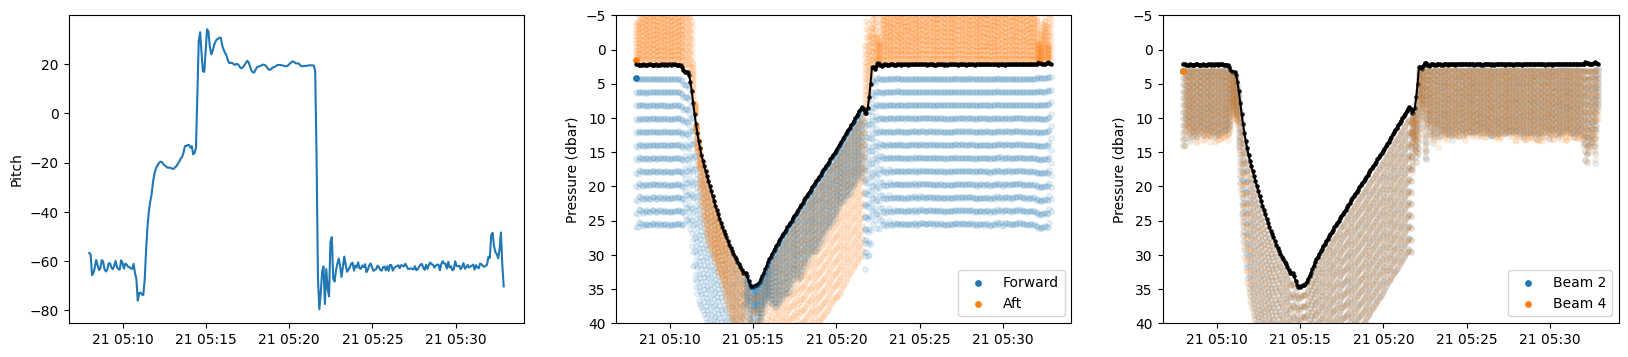

In [6]:
ADCP = process_adcp.remapADCPdepth(ADCP, options)

## 1.4 Correct ADCP Heading

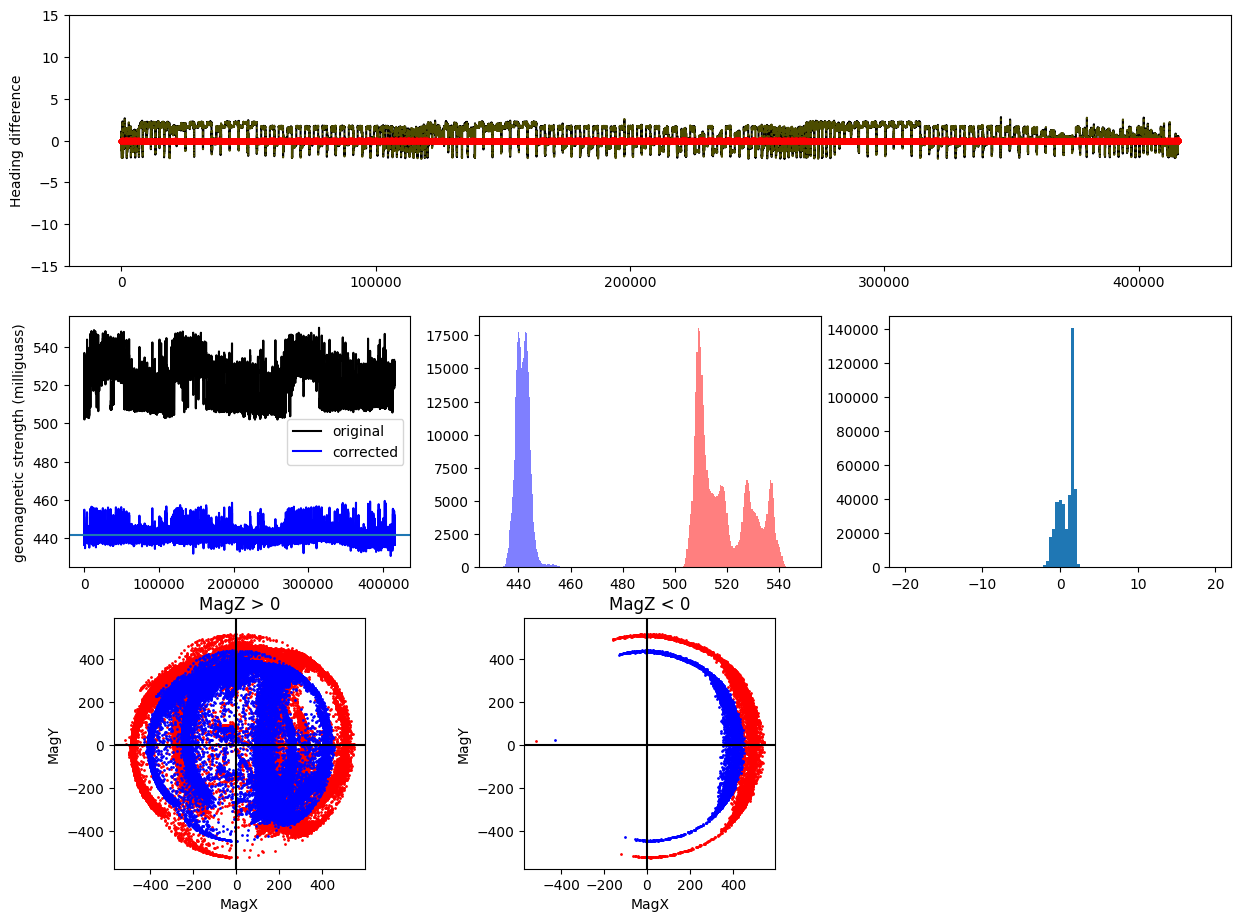

In [7]:
ADCP = process_adcp.correct_heading(ADCP, data, options)

## 1.5 Perform soundspeed correction

In [8]:
ADCP = process_adcp.soundspeed_correction(ADCP)

## 1.6 Outlier and poor correlation removal


Now we need to think. What do we discard, what do we keep, do we interpolate across missing bins?

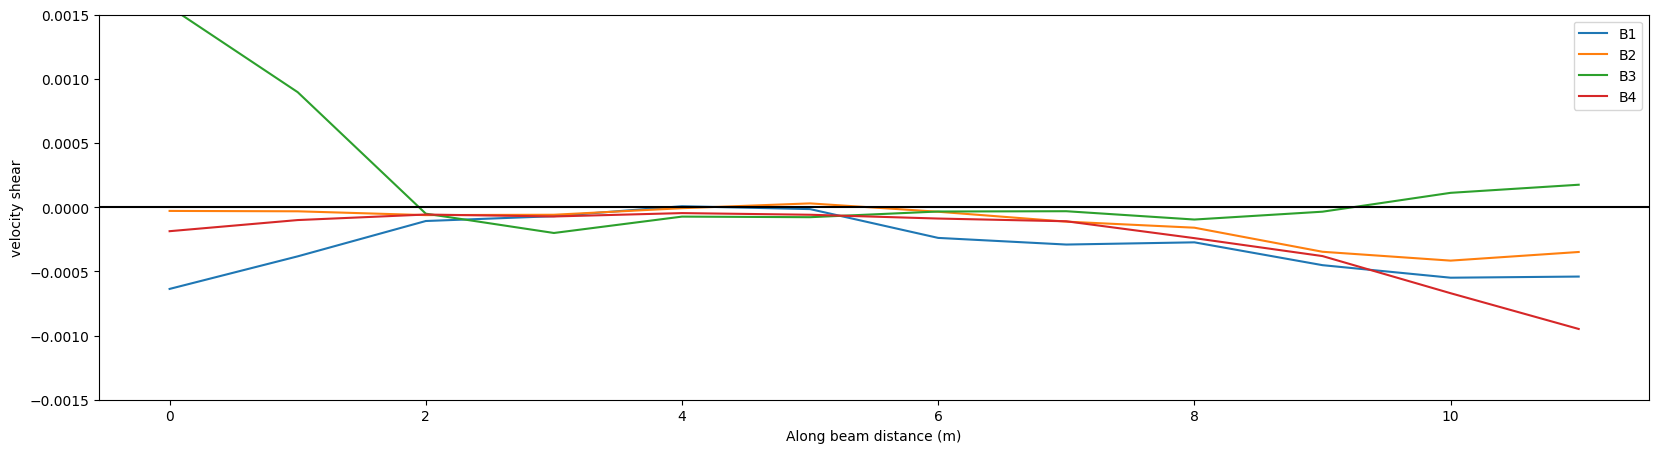

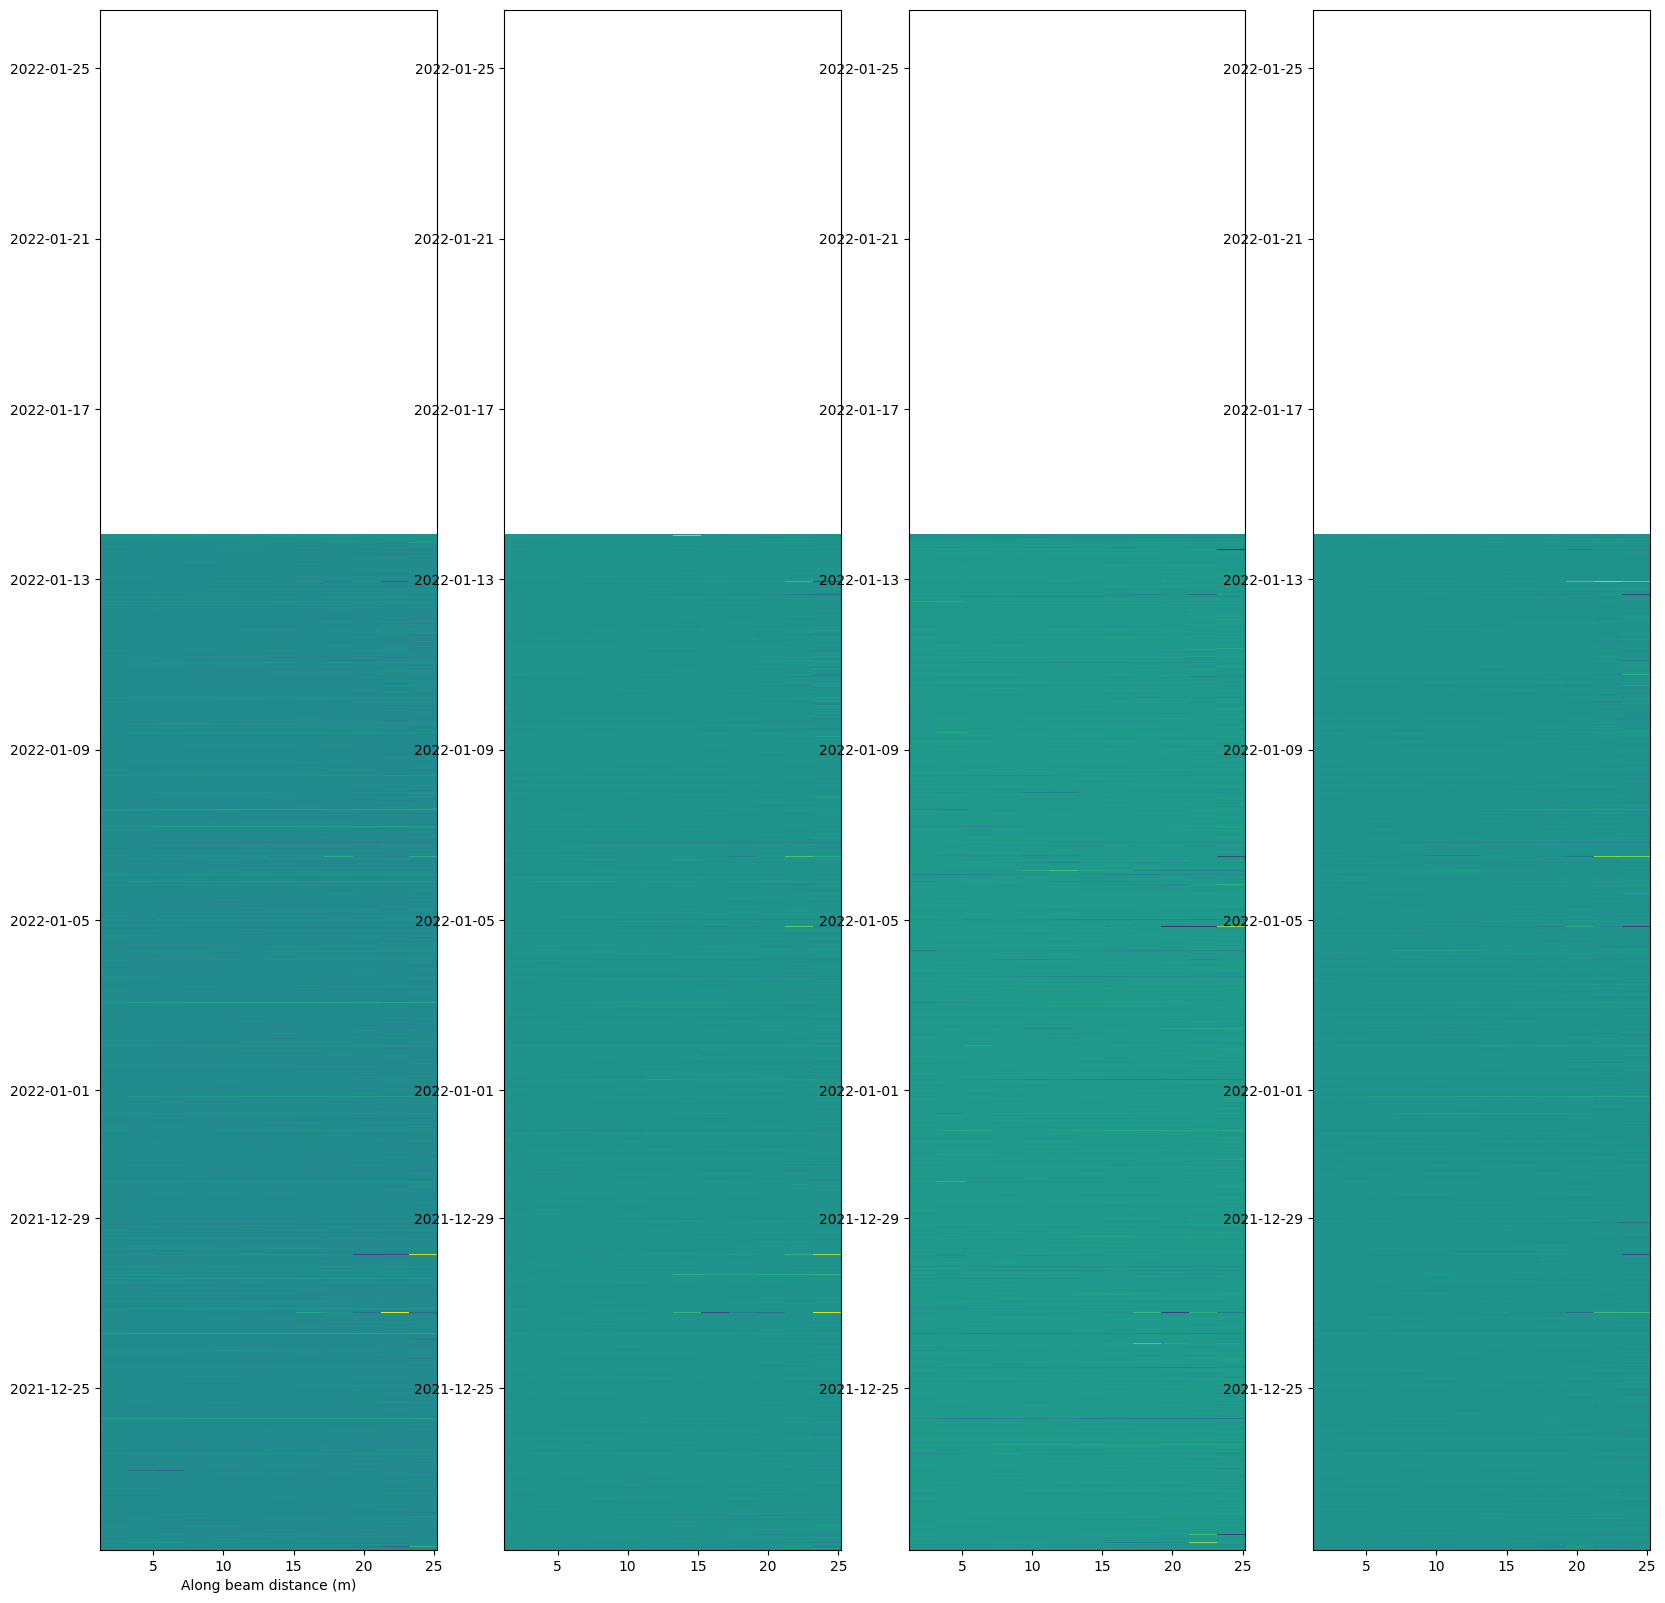

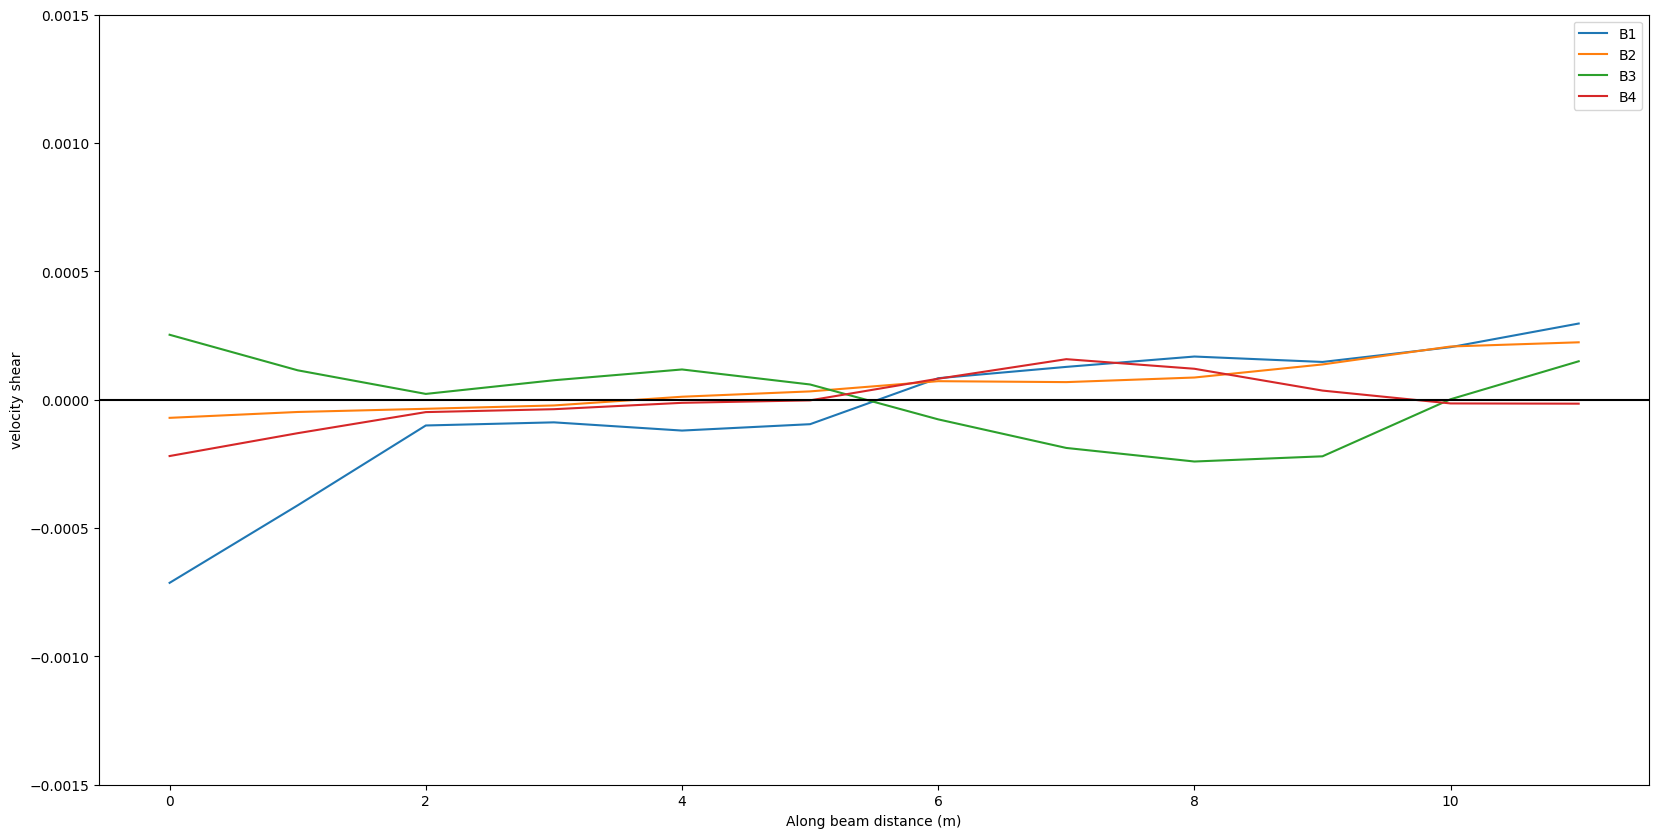

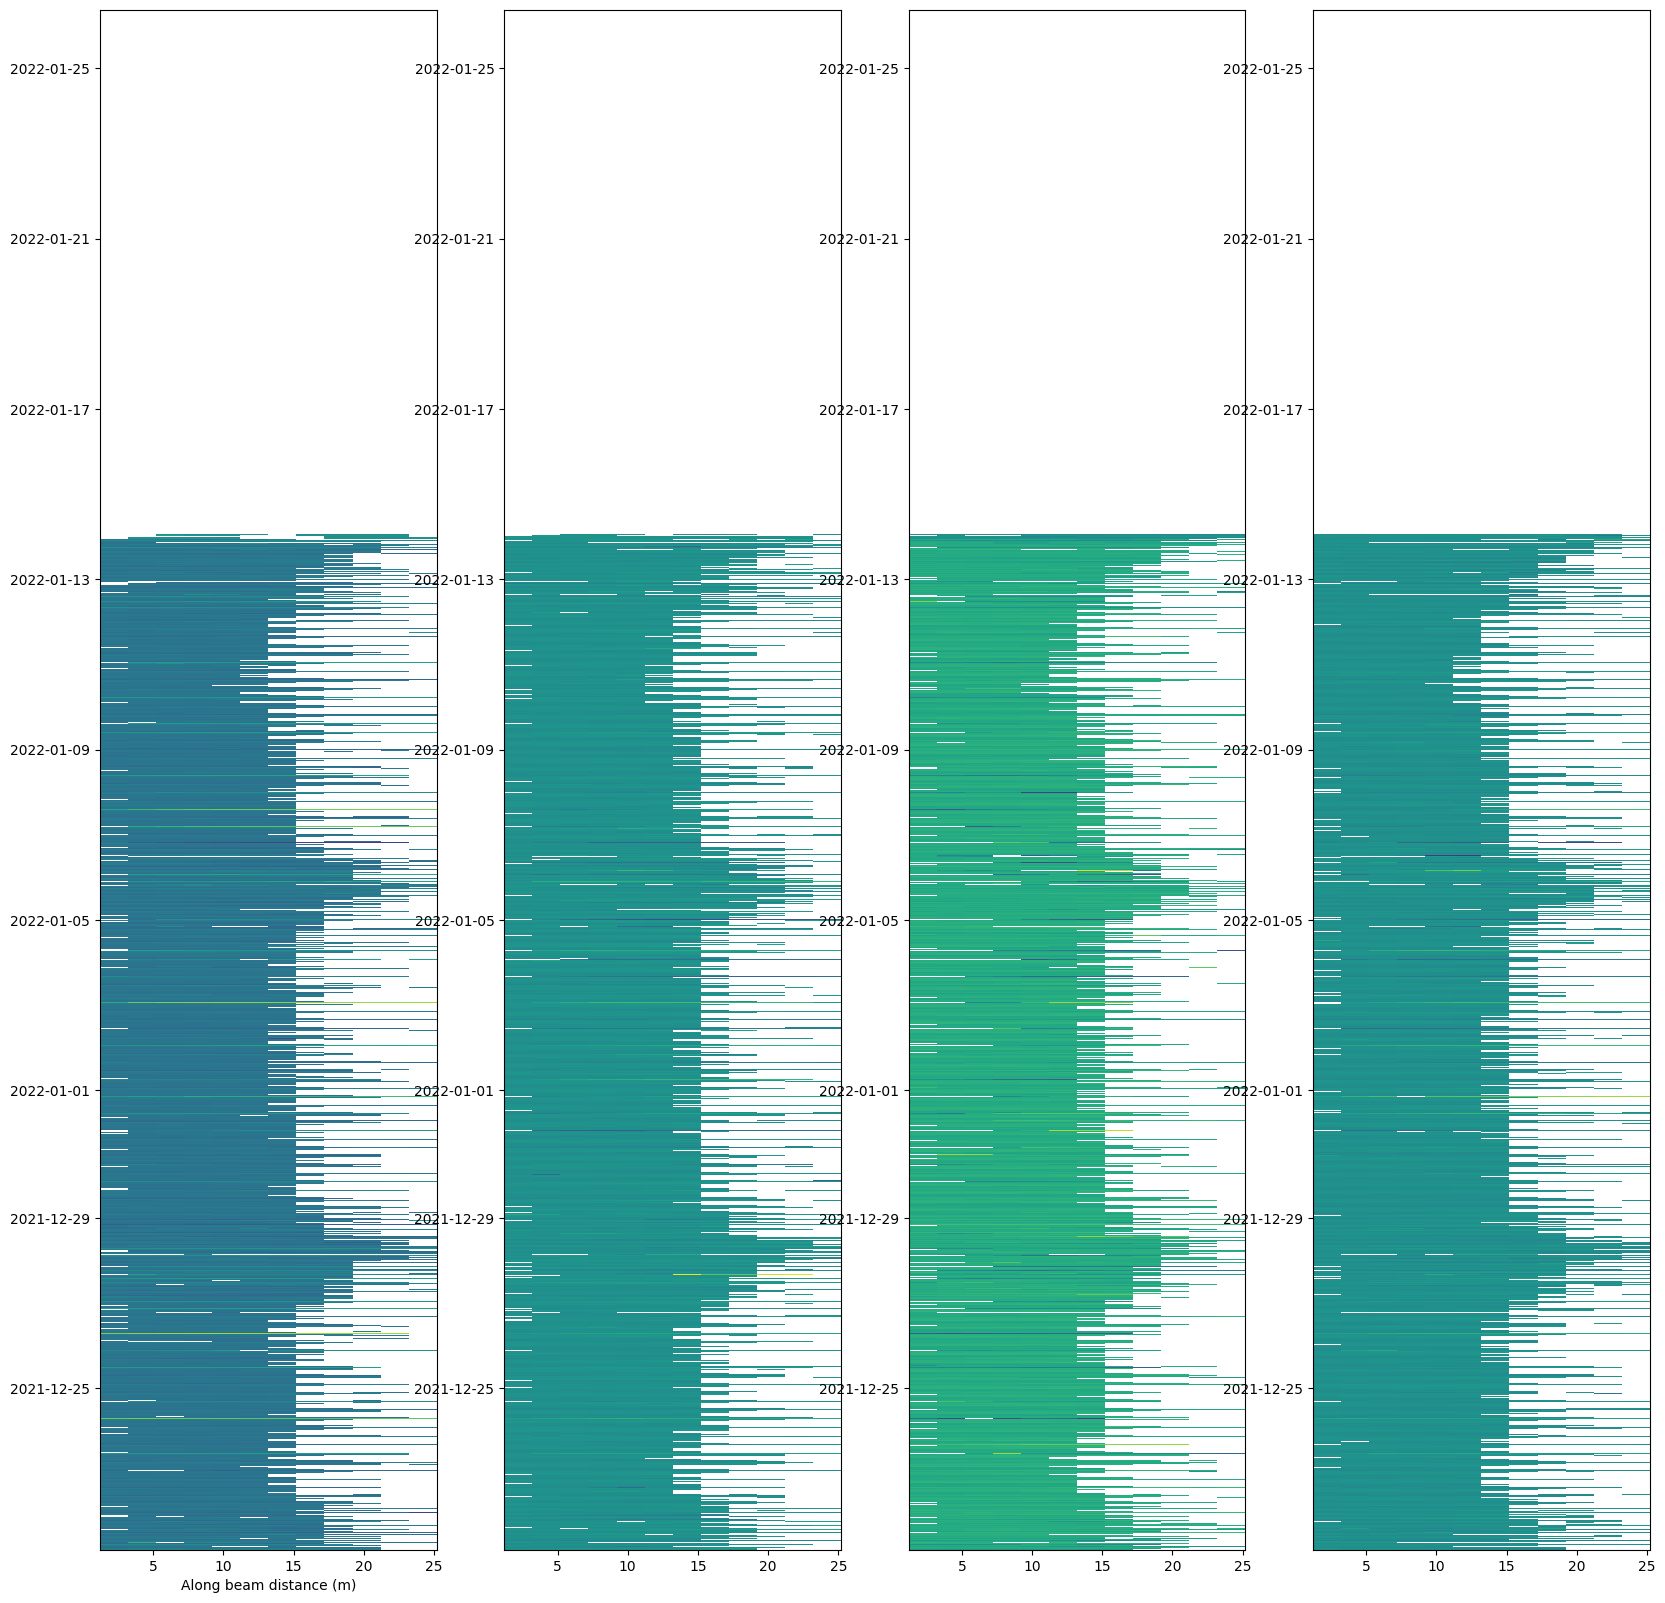

In [9]:
ADCP = process_adcp.remove_outliers(ADCP, options)

## 1.7 How many good data per bin?

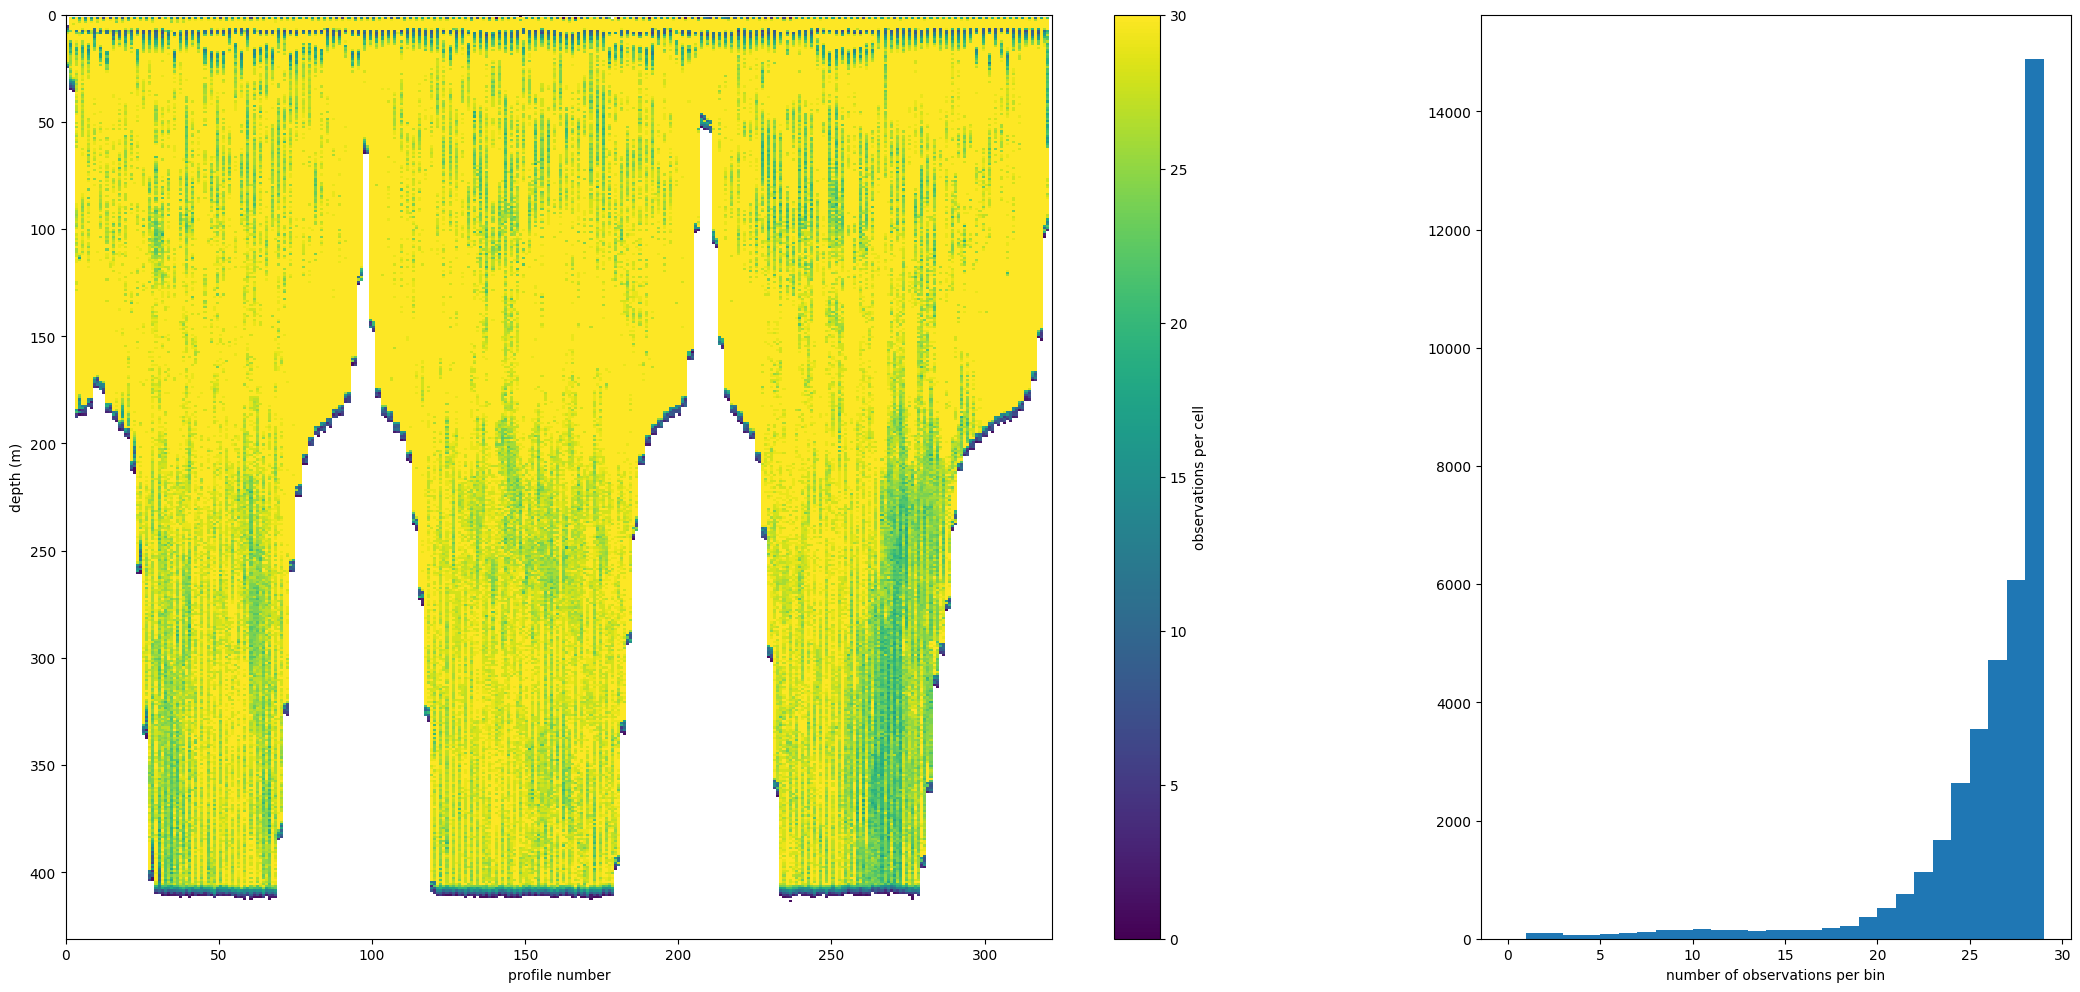

In [10]:
process_adcp.plot_data_density(ADCP, options)

### 1.8 Correct shear bias

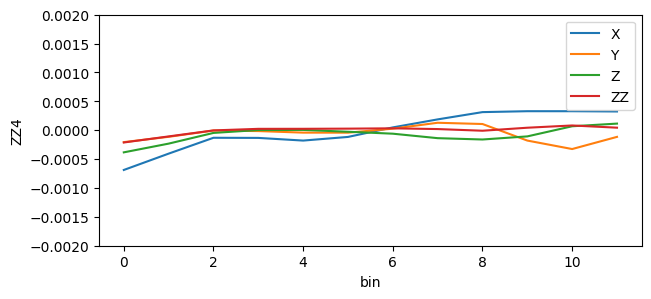

In [11]:
ADCP = process_adcp.correct_shear(ADCP, options)

## 1.9 Remap 3-beam configuration onto isobars

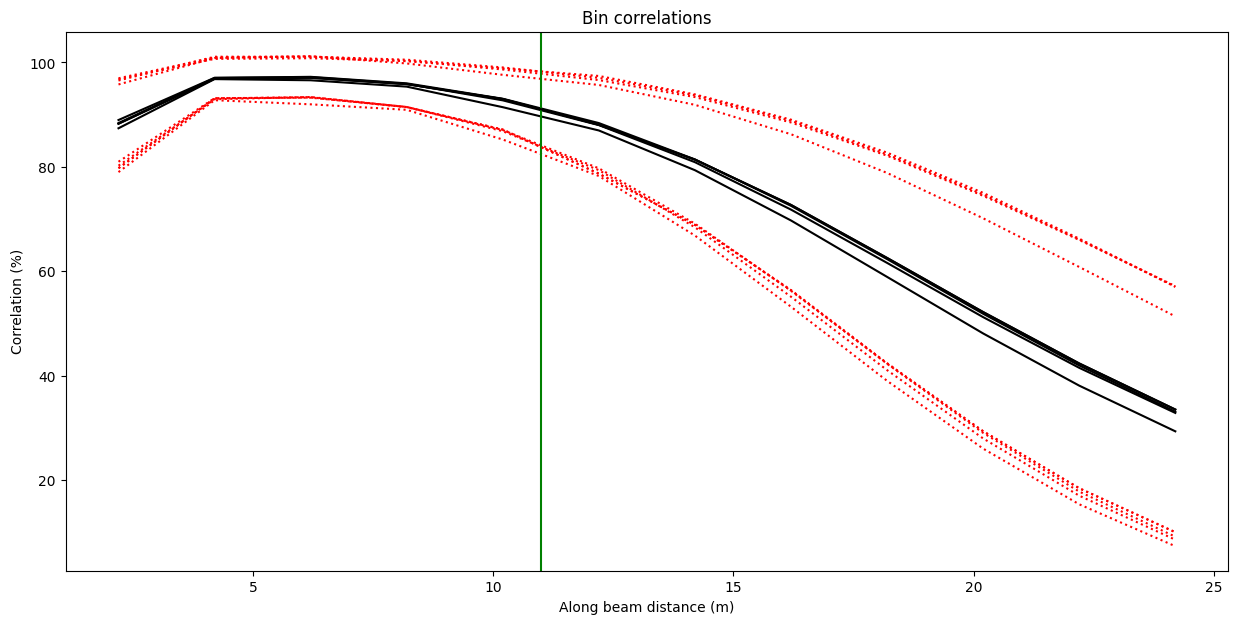

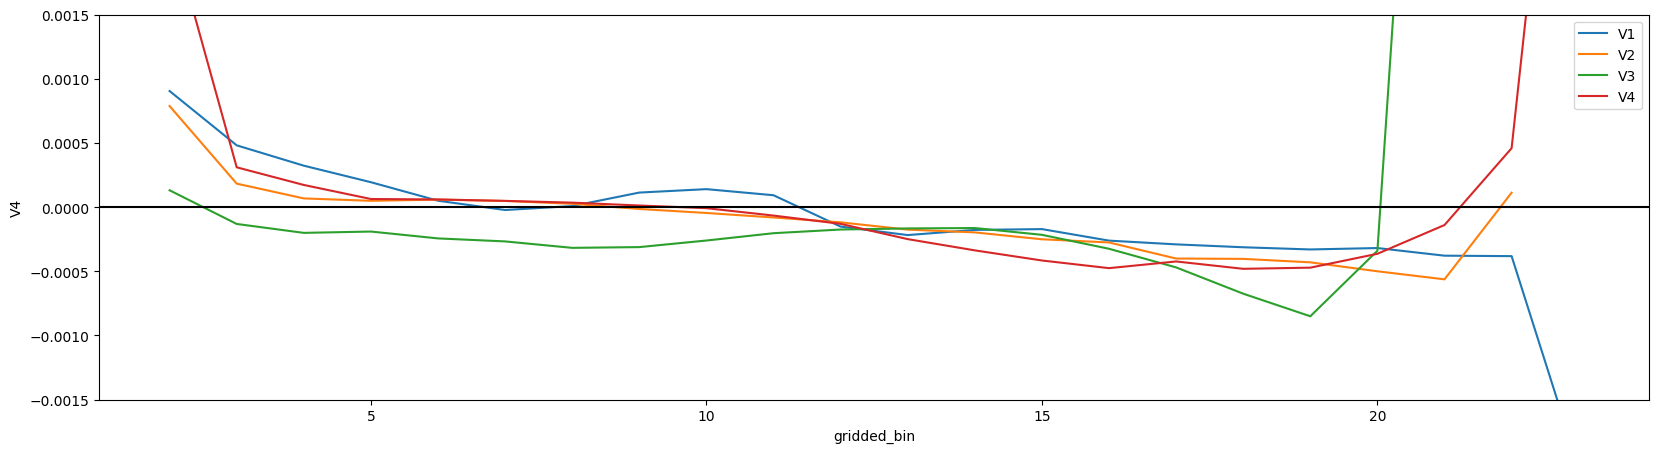

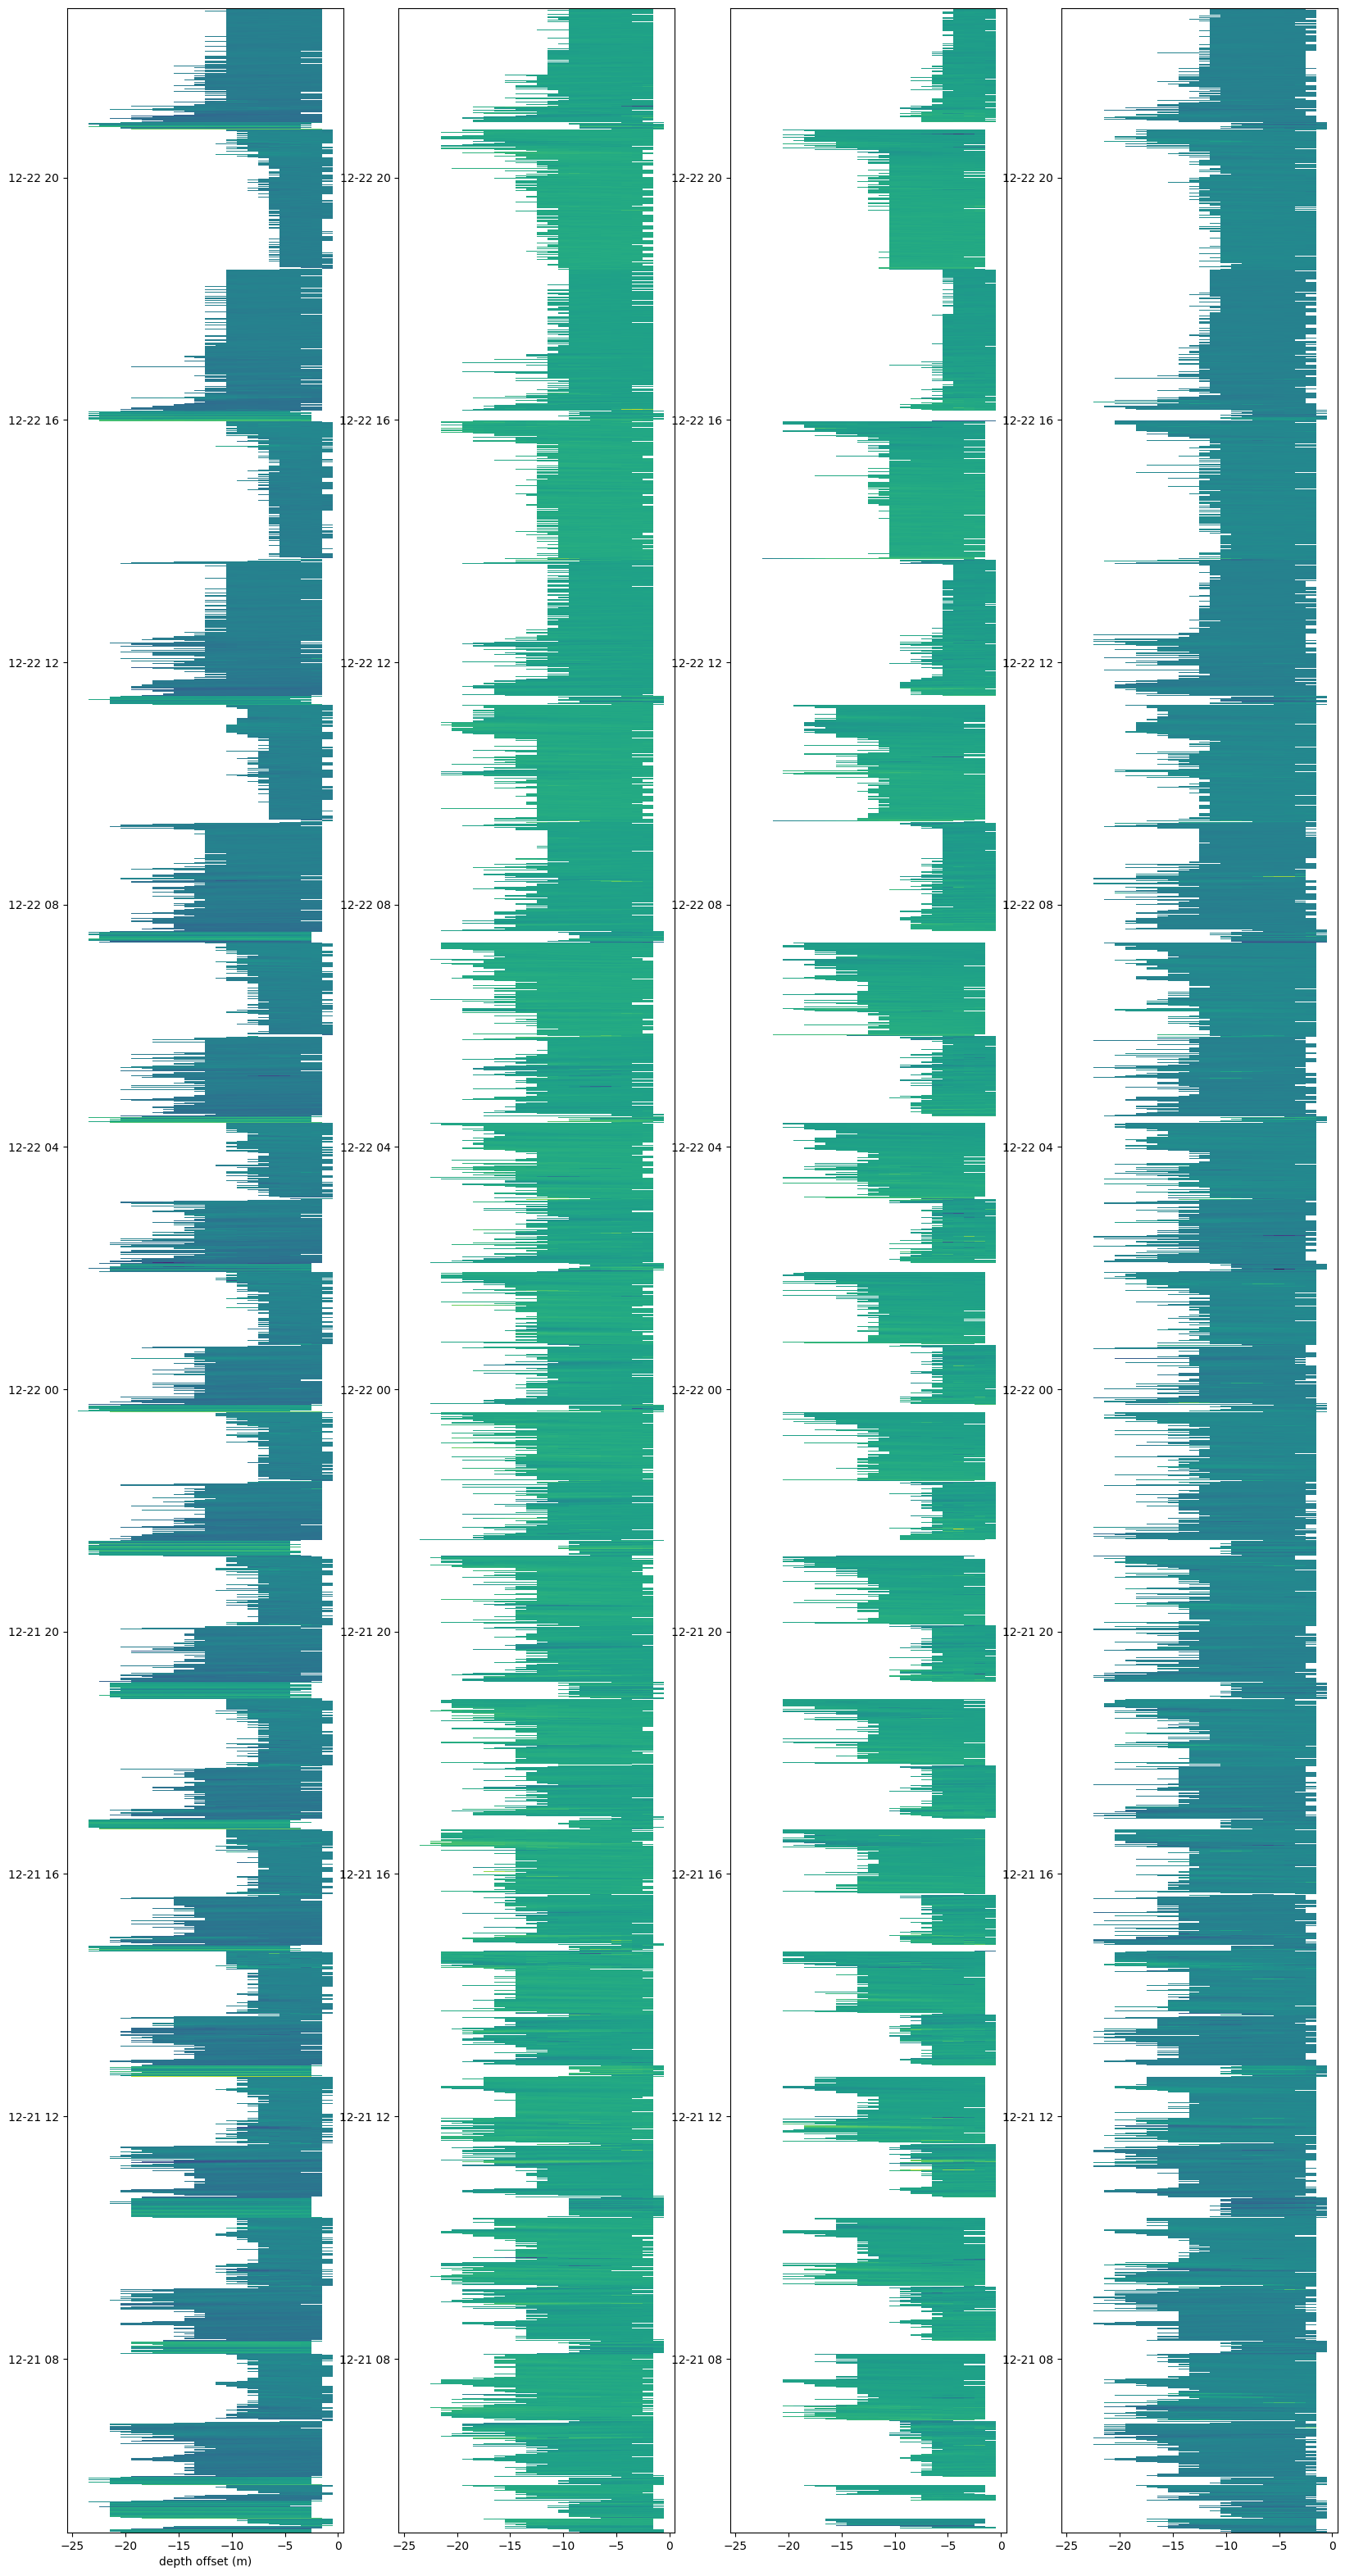

In [12]:
ADCP = process_adcp.regridADCPdata(ADCP, options)

## 1.10 Transform beams to XYZ and ENU velocities

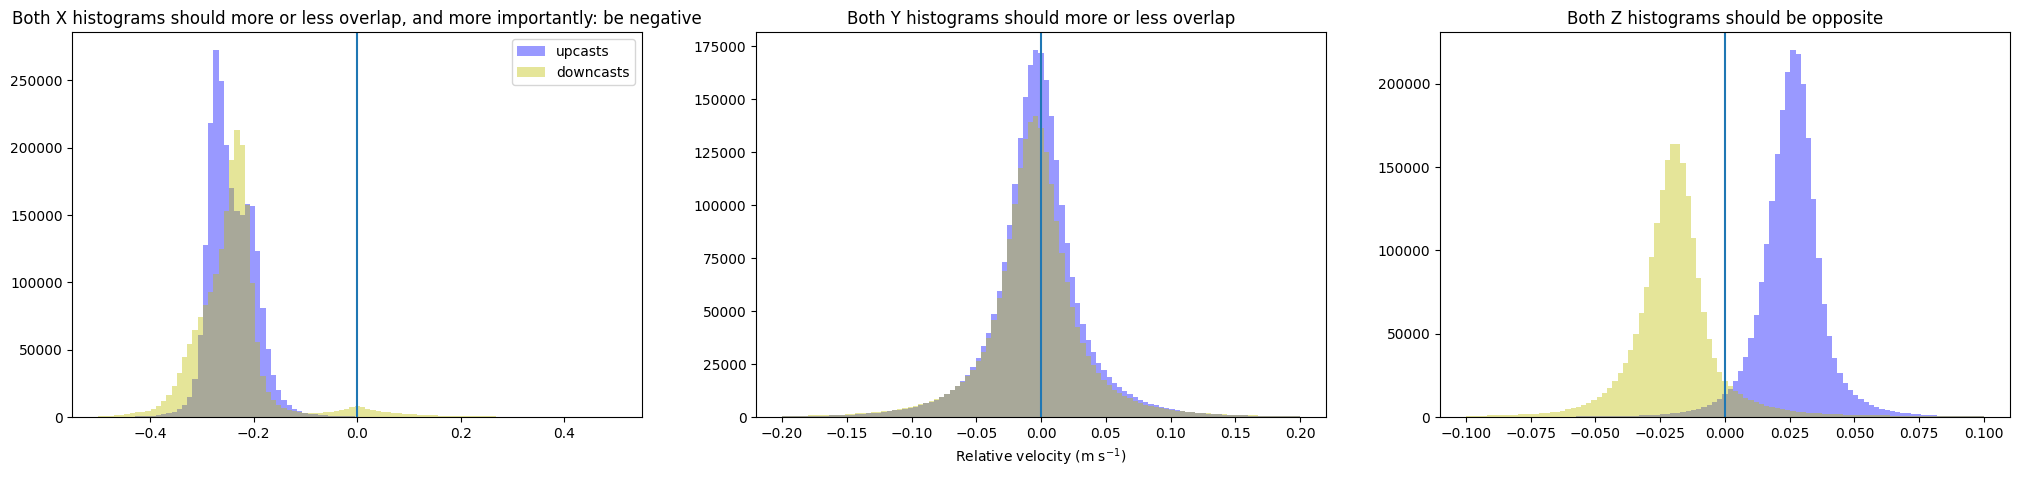

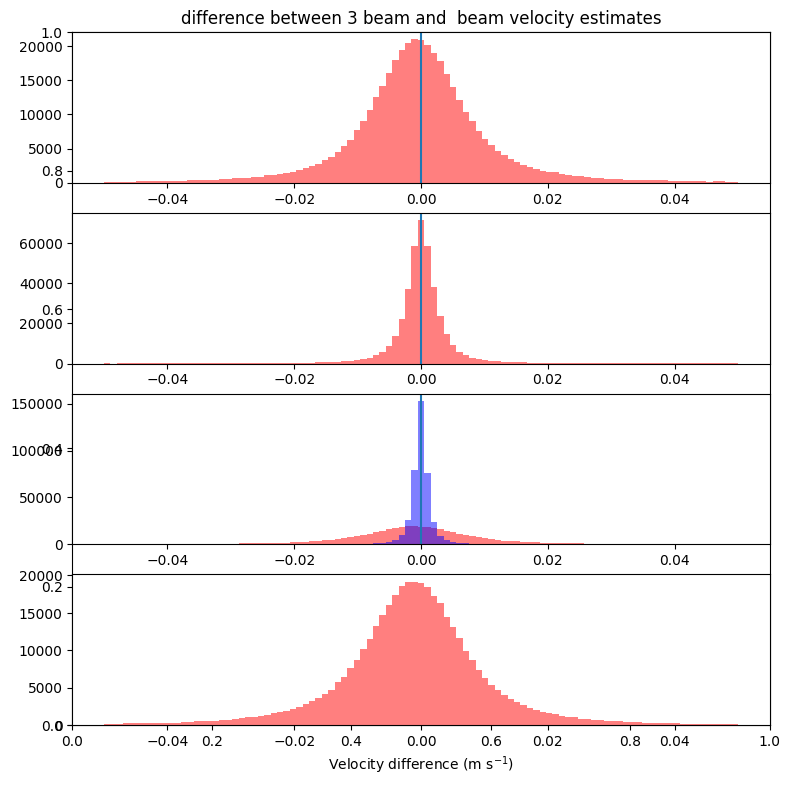

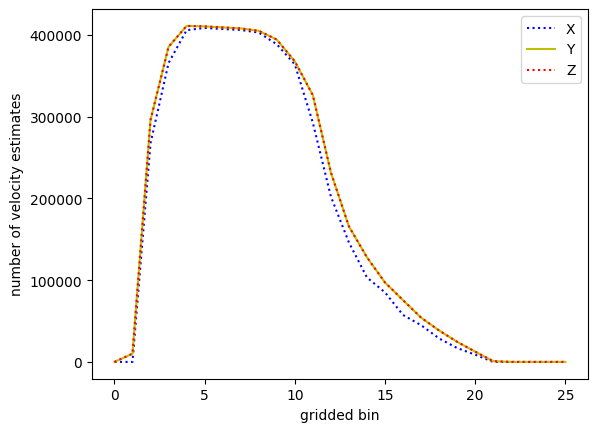

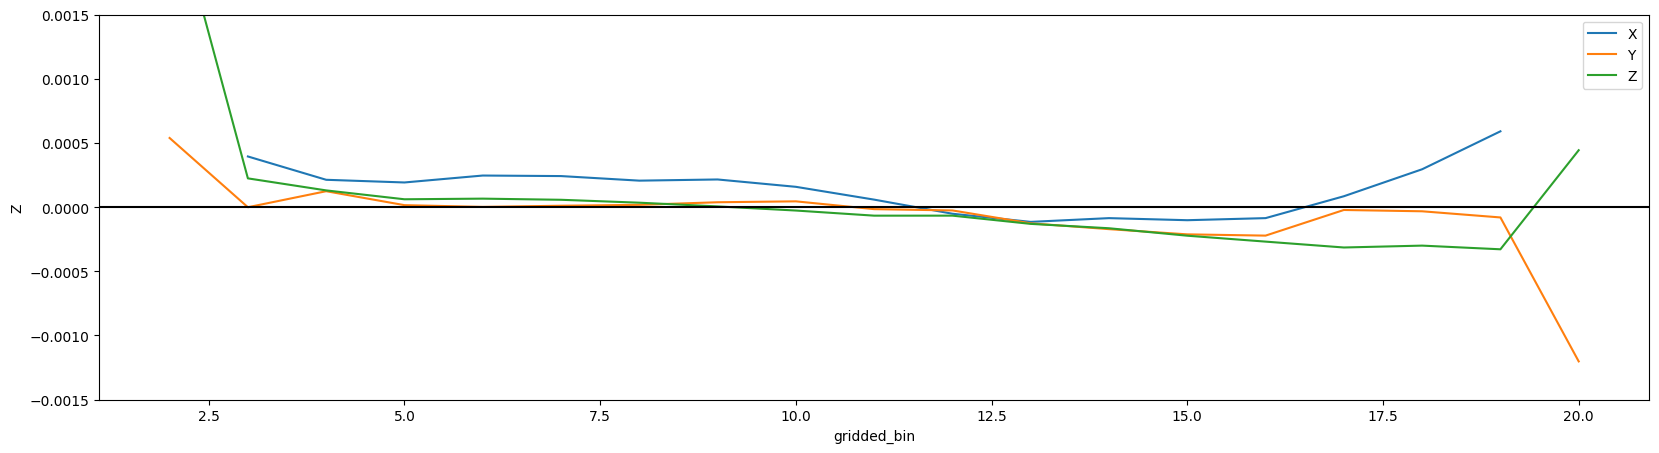

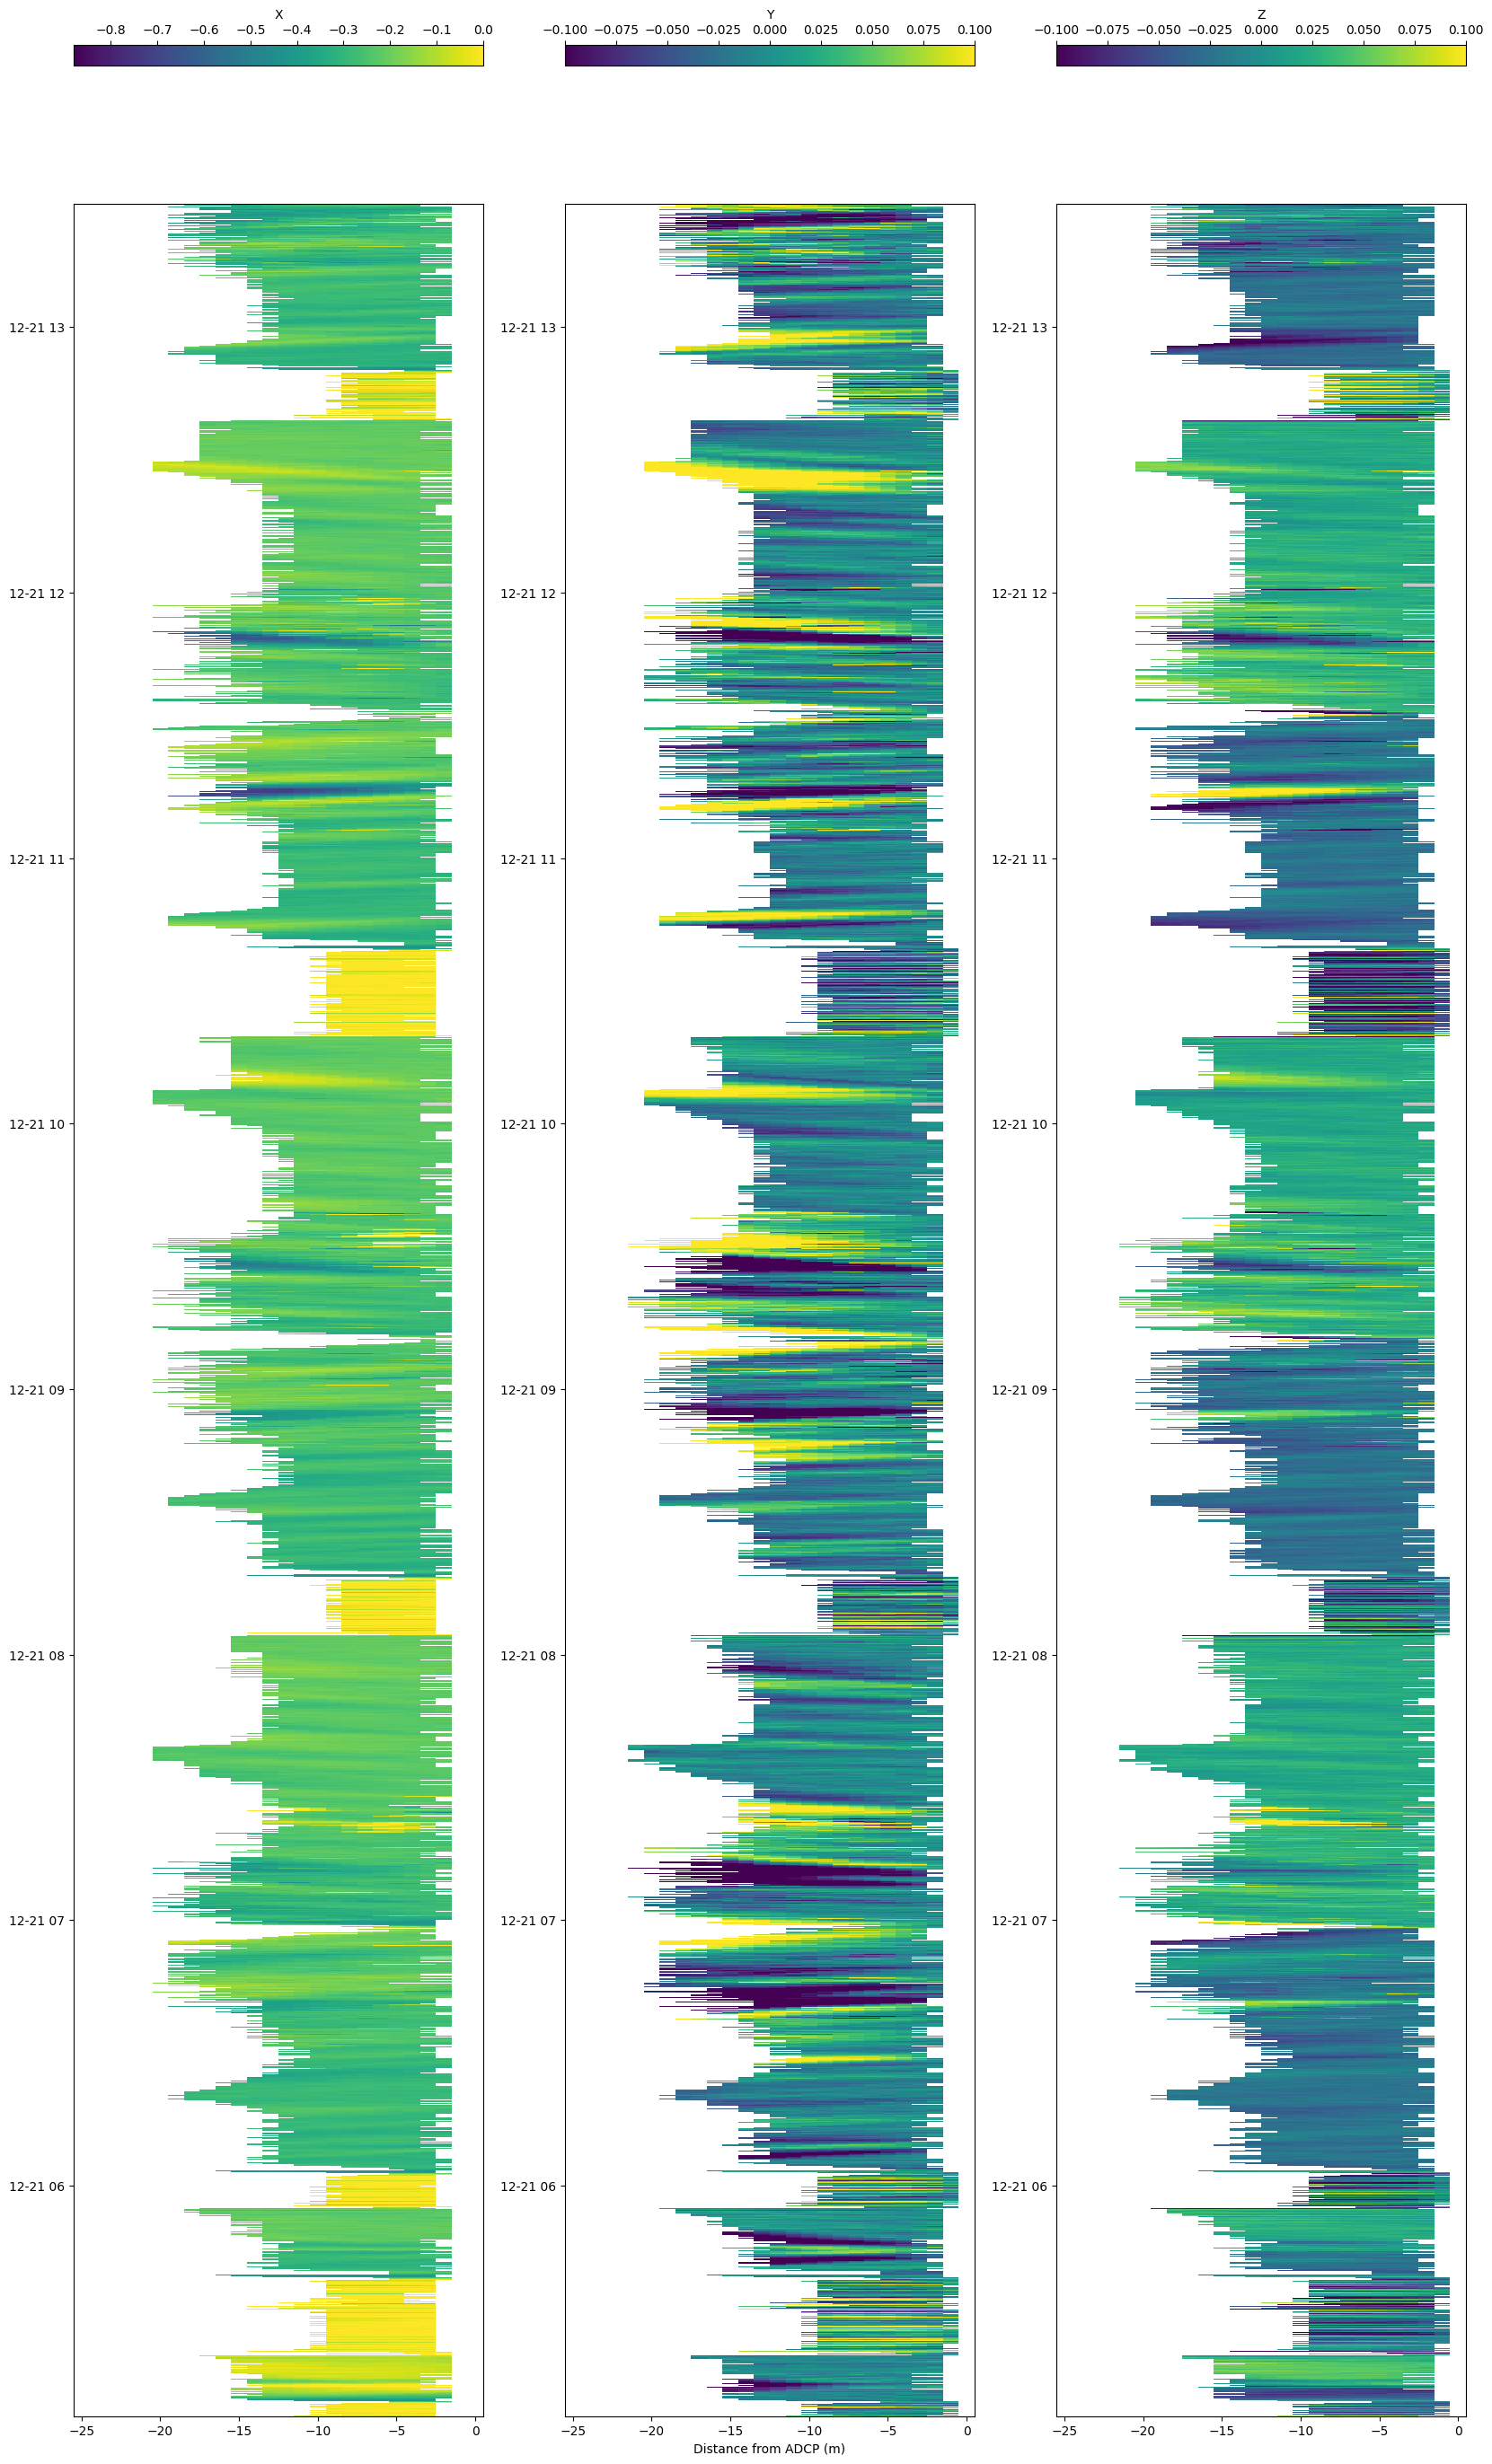

In [13]:
ADCP = process_adcp.calcXYZfrom3beam(ADCP, options)

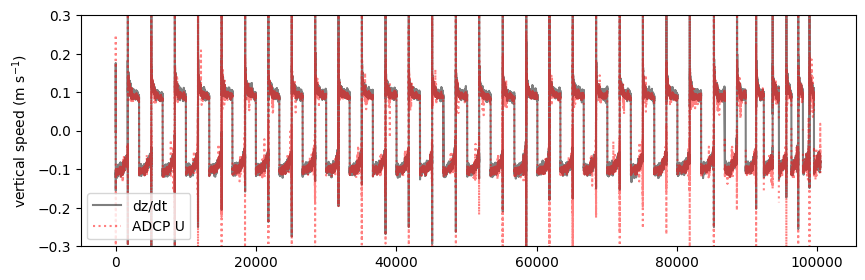

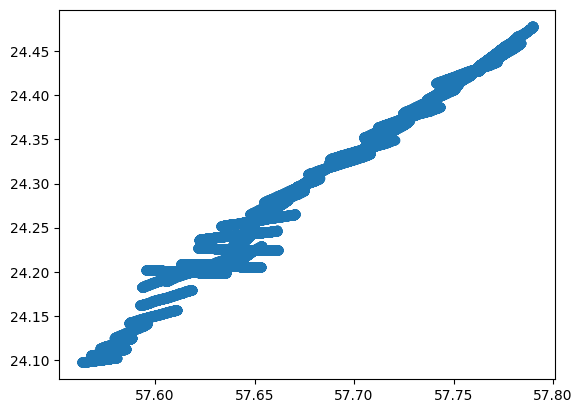

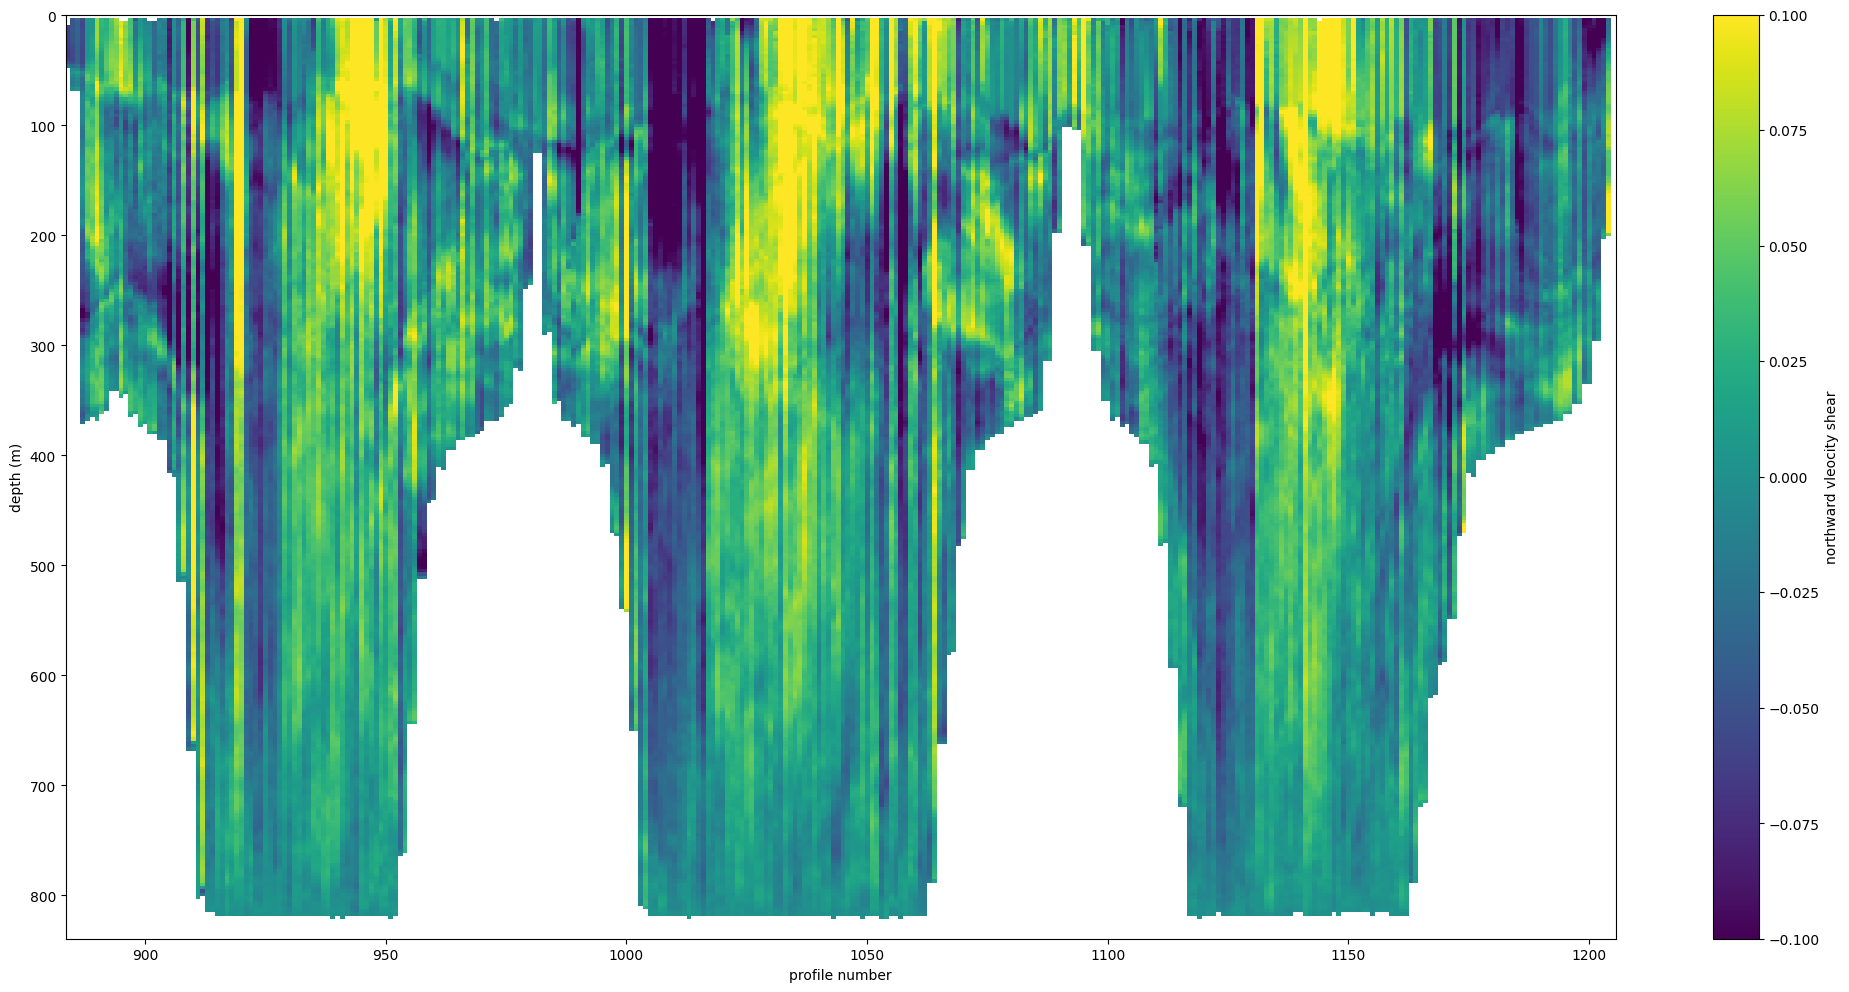

In [14]:
ADCP = process_adcp.calcENUfromXYZ(ADCP, data, options)

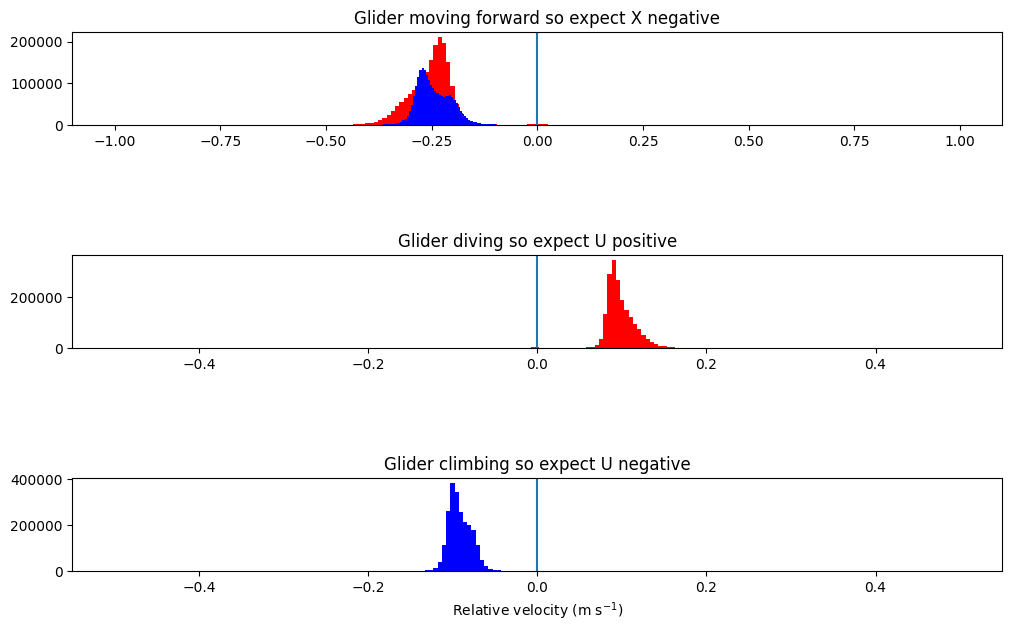

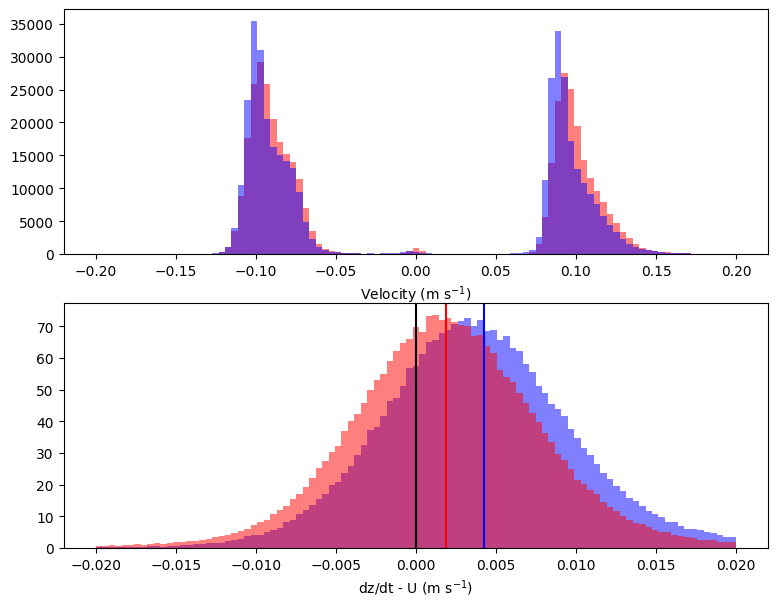

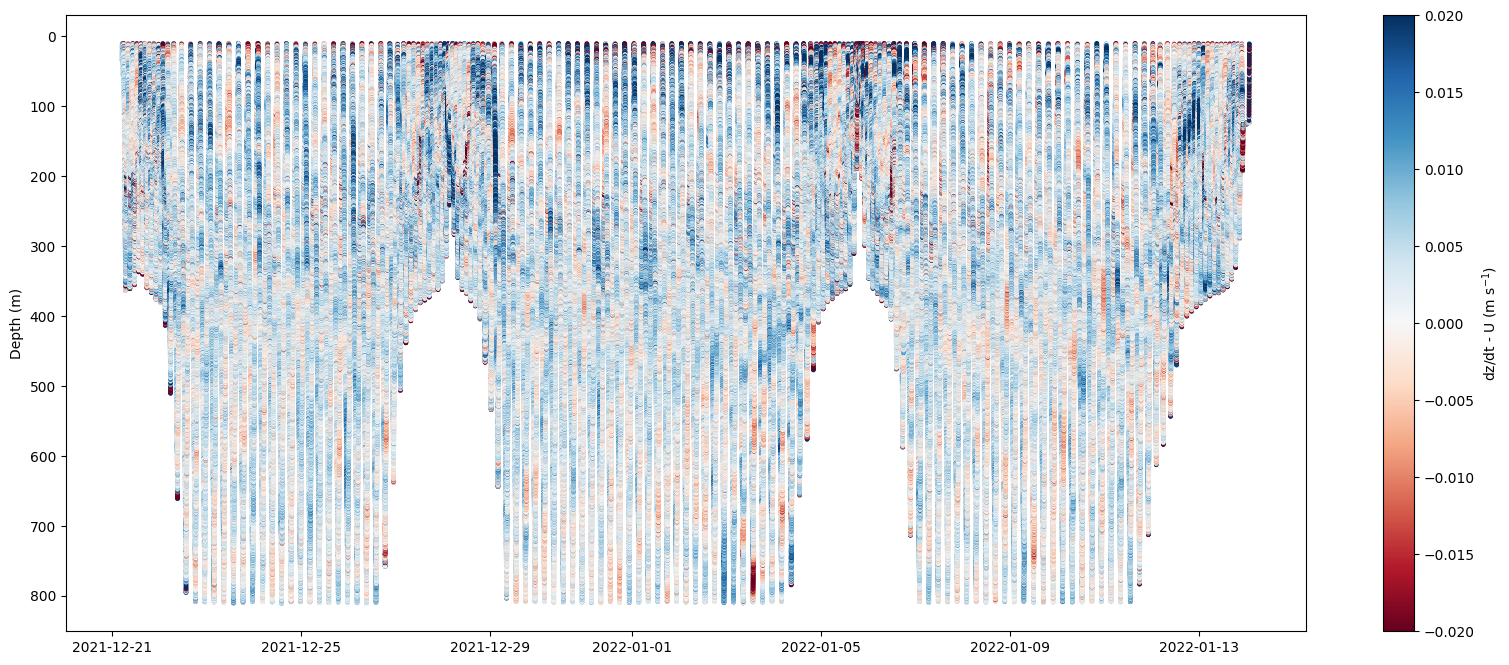

In [15]:
process_adcp.verify_calcENUfromXYZ(ADCP, options)

## 1.11 Grid shear

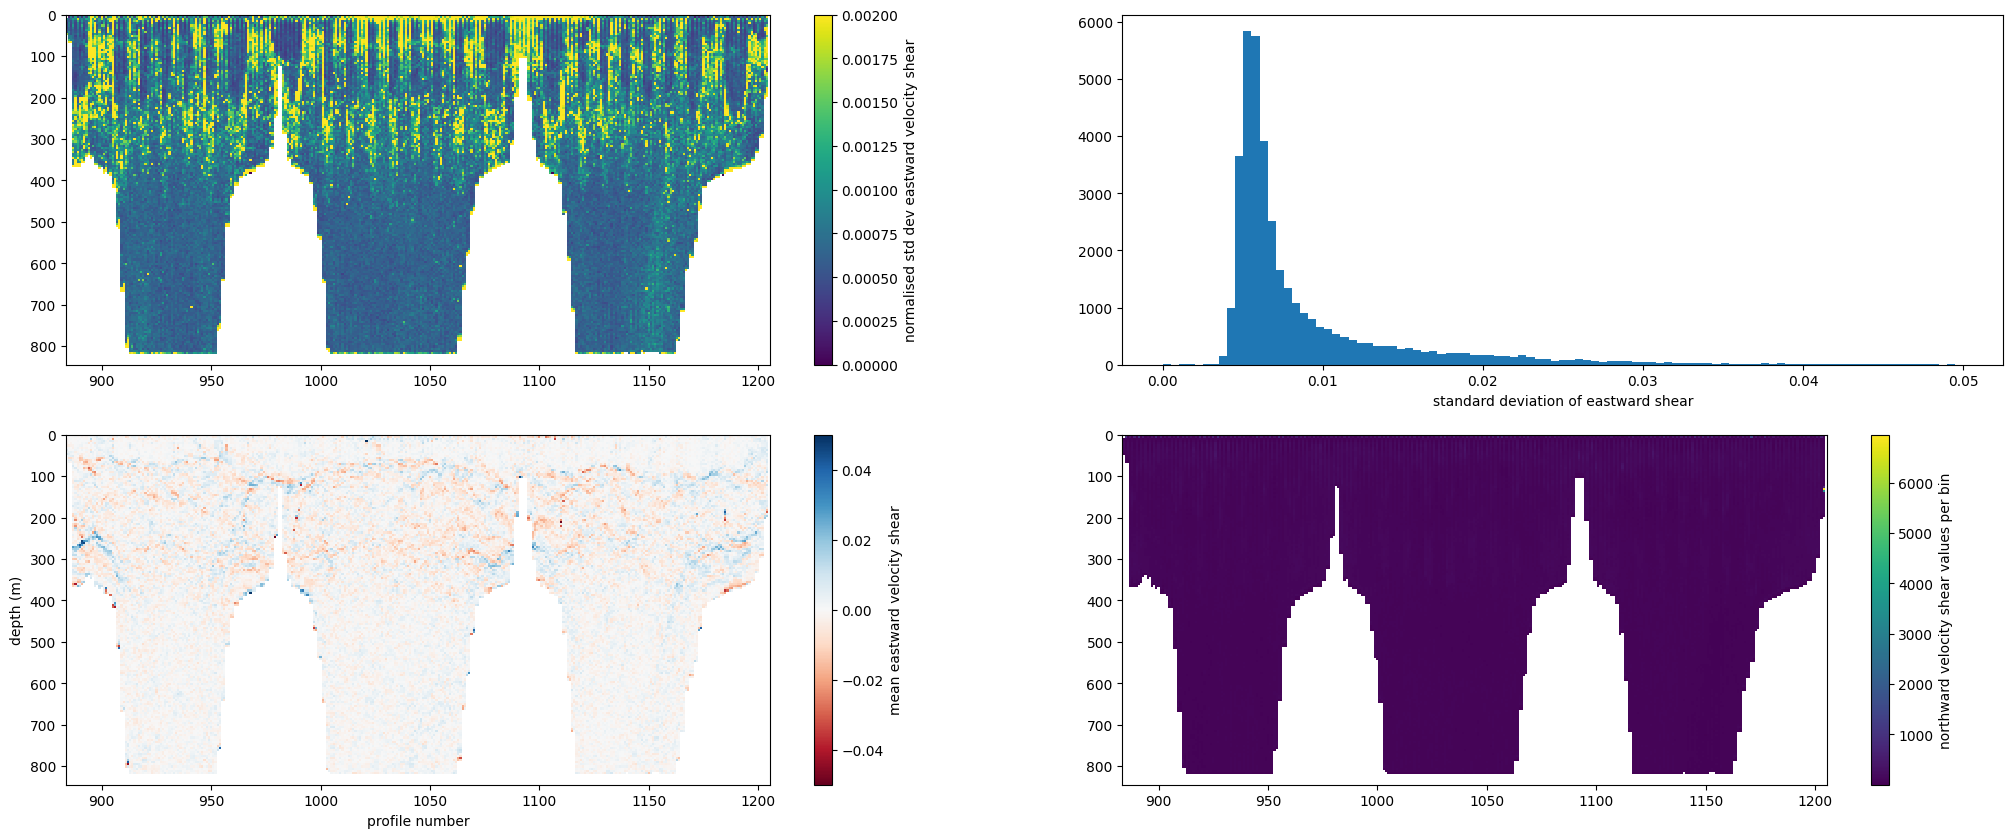

In [16]:
xaxis, yaxis, taxis, days = process_adcp.grid_shear_data(ADCP, data, options)
out = process_adcp.grid_data(ADCP, data, {}, xaxis, yaxis)
ds = process_adcp.make_dataset(out)

# 1.12 Write out data

**ds** is an xarray dataset of data gridded by depth bin and profile number, ready for processing

In [18]:
ds.to_netcdf("gridded_shear.nc")

# Part 2: shear to velocity

After calculating velocity shear, there are several options for integrating and referencing this shear to obtain velocity profiles. This section demonstrates some of these options

# 2.1 Add extra variables for integrating shear

To calculate dive average current we require more variables, including estimates of the glider's movement through the water.

In [19]:
import pandas as pd

extra_data = pd.read_parquet(glider_pqt_path)
extra_data.index = data.index
data["speed_vert"] = extra_data["speed_vert"]
data["speed_horz"] = extra_data["speed_horz"]
data["dead_reckoning"] = extra_data["dead_reckoning"]
data["nav_resource"] = extra_data["nav_state"]
data["dive_number"] = extra_data["dive_number"]

## 2.2. Calculate dive-averaged current

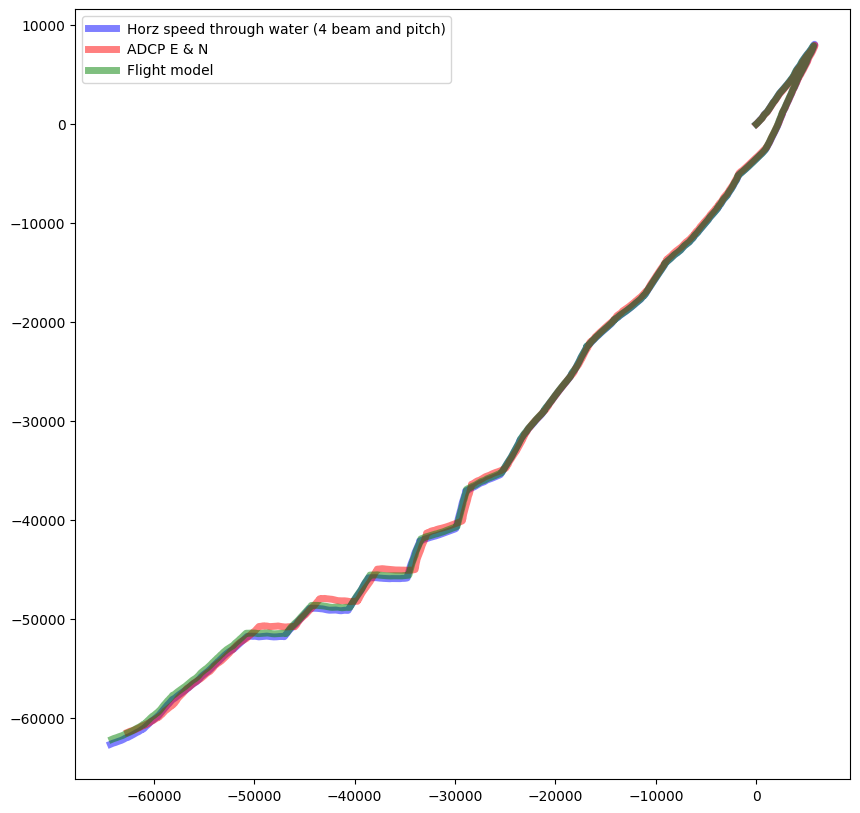

In [20]:
process_adcp.plot_subsurface_movement(ADCP, data, options)

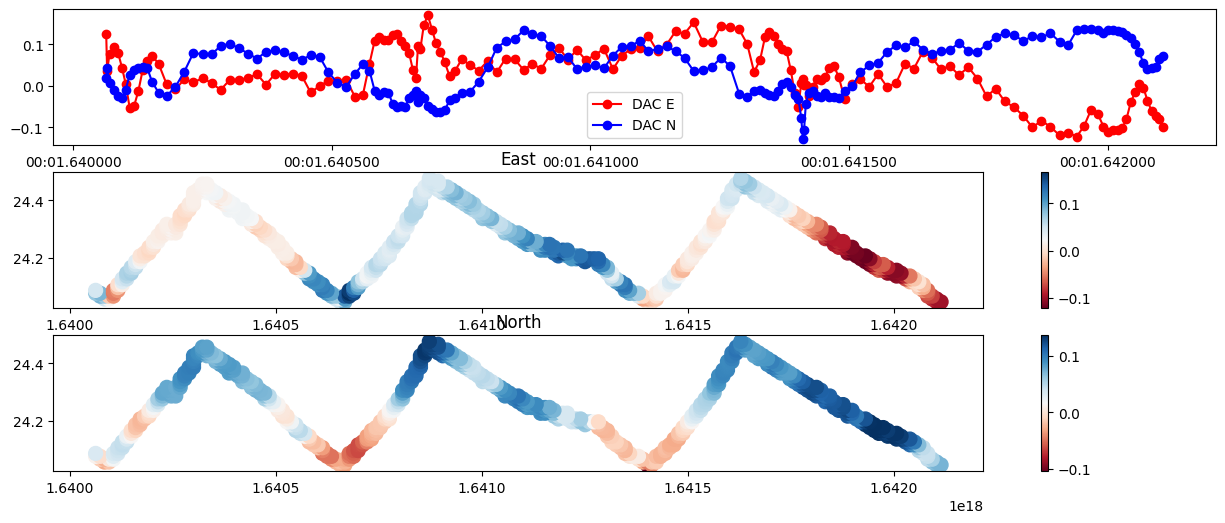

In [21]:
data = process_adcp.get_DAC(ADCP, data, options)

## 2.3. Get surface drift

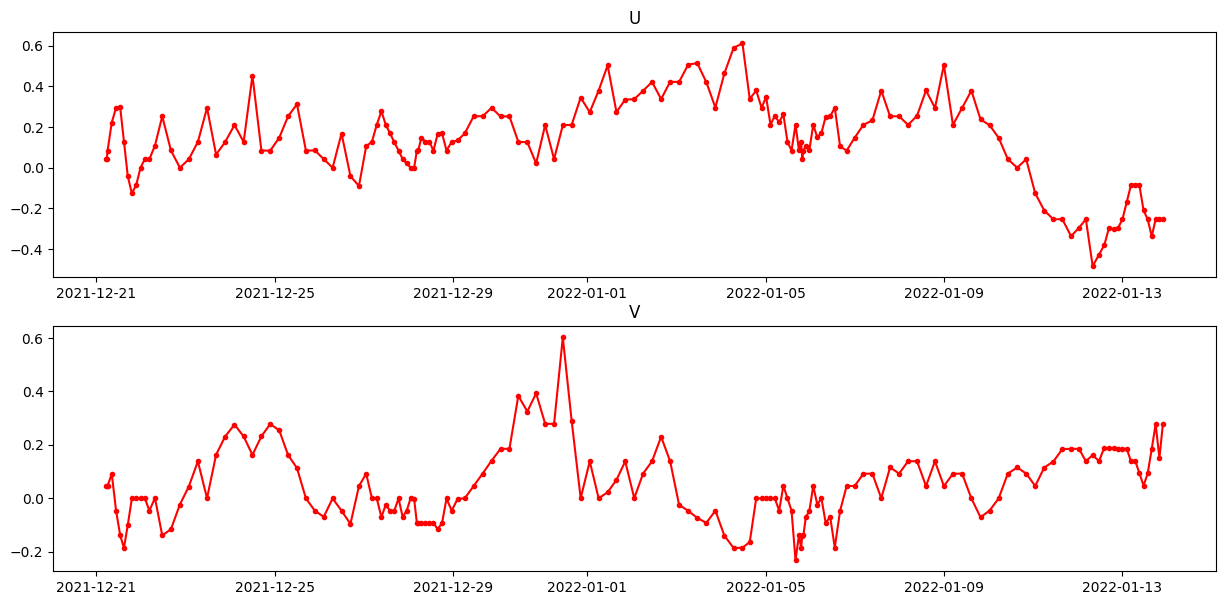

In [22]:
dE,dN,dT = process_adcp.getSurfaceDrift(data, options)

## 2.4. Get bottom track data 
Bottom track data only calculated if the ADCP is bottom mounted

In [23]:
ADCP = process_adcp.bottom_track(ADCP, adcp_path, options)

## 2.5. Reference ADCP data

Here we reference data to dive average current (DAC).

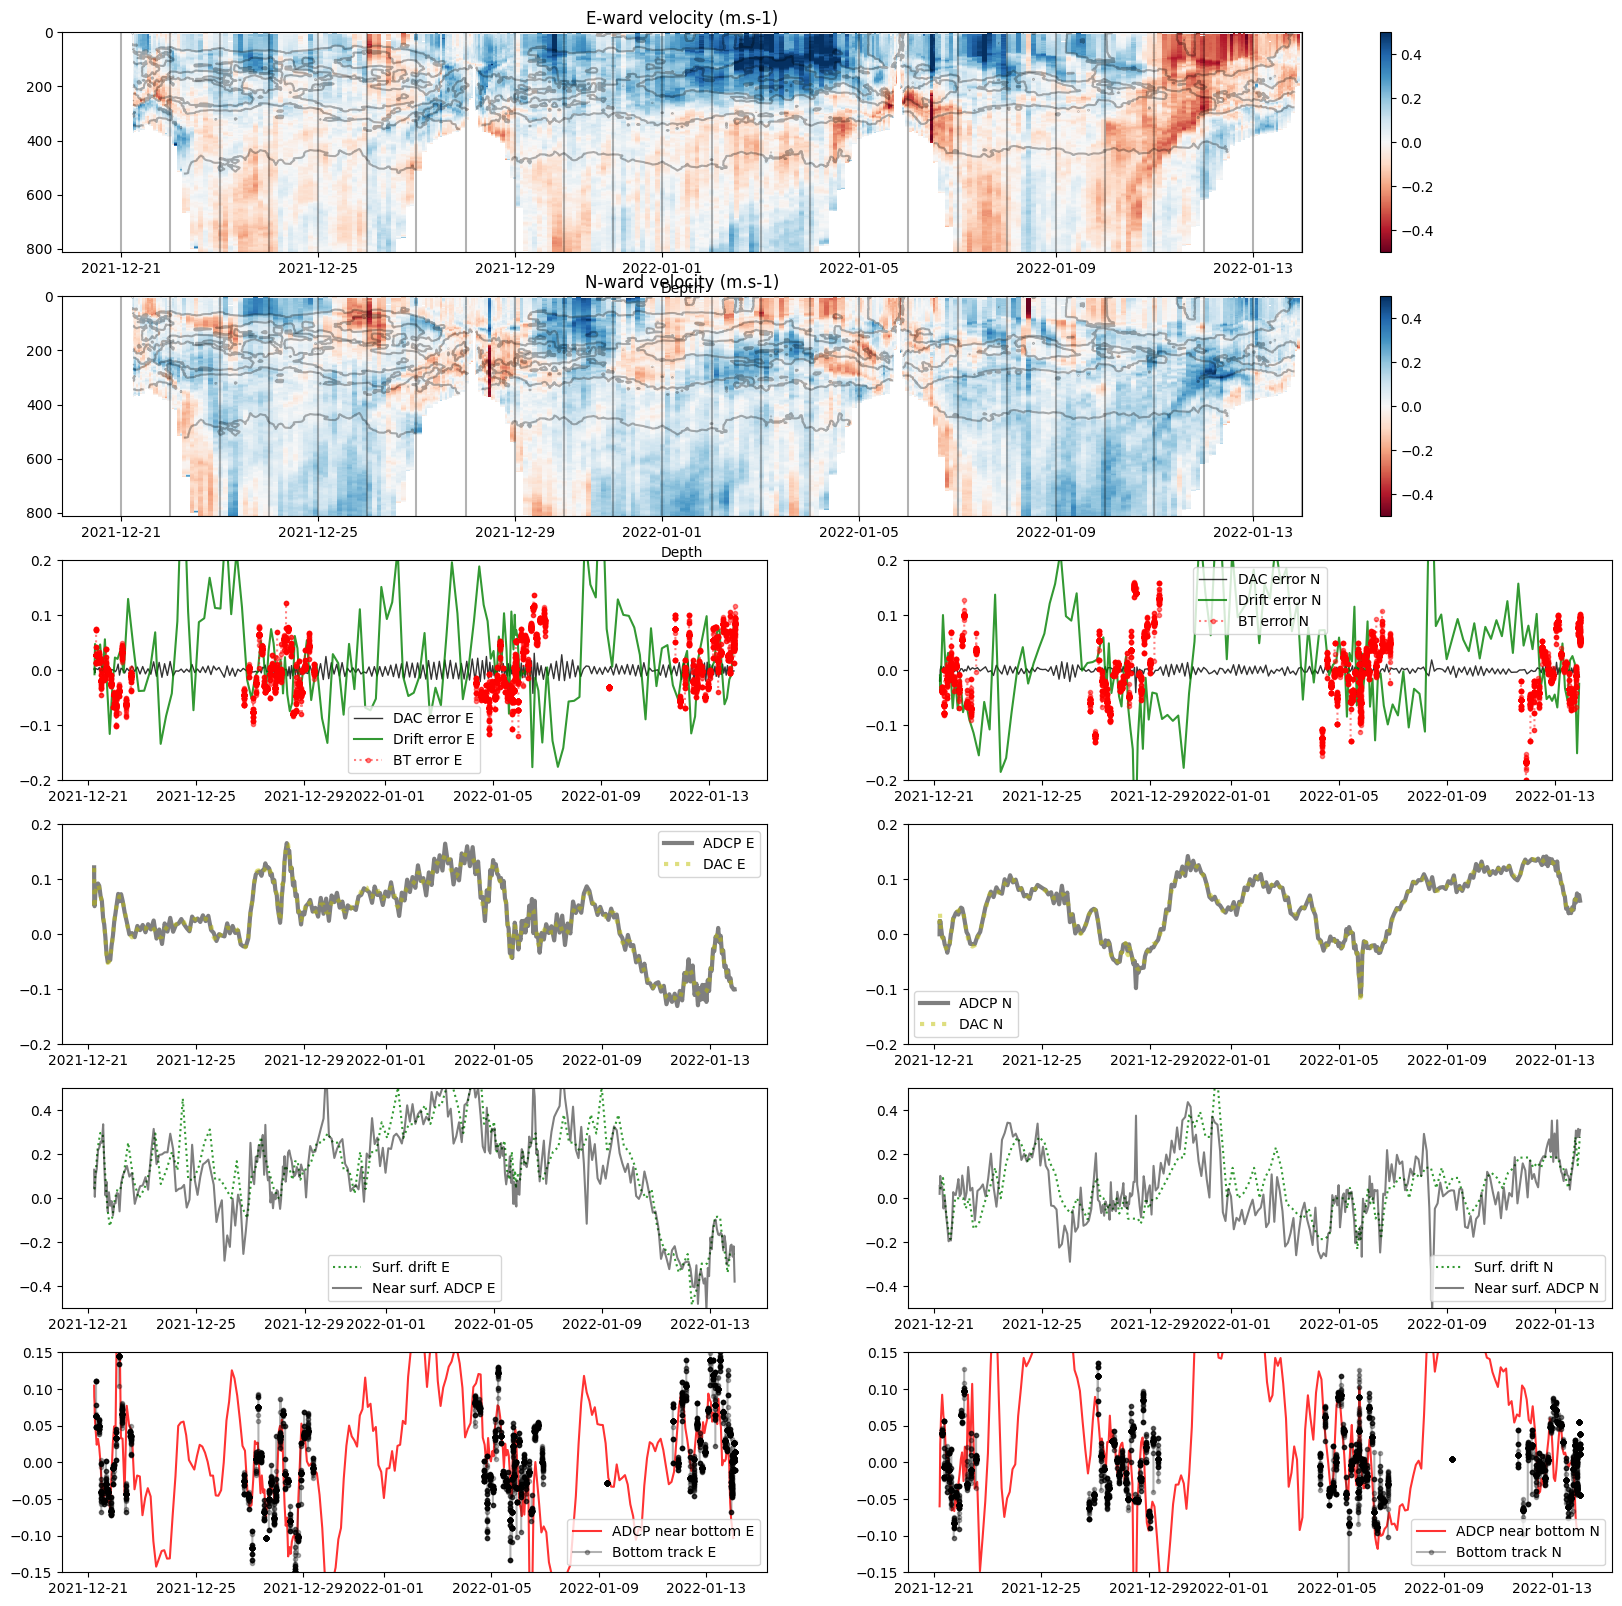

In [24]:
out = process_adcp.reference_shear(ADCP, data, dE,dN,dT, xaxis, yaxis, taxis, options)

## 2.6 Grid and plot data

In [25]:
out = process_adcp.grid_data(ADCP, data, out, xaxis, yaxis)

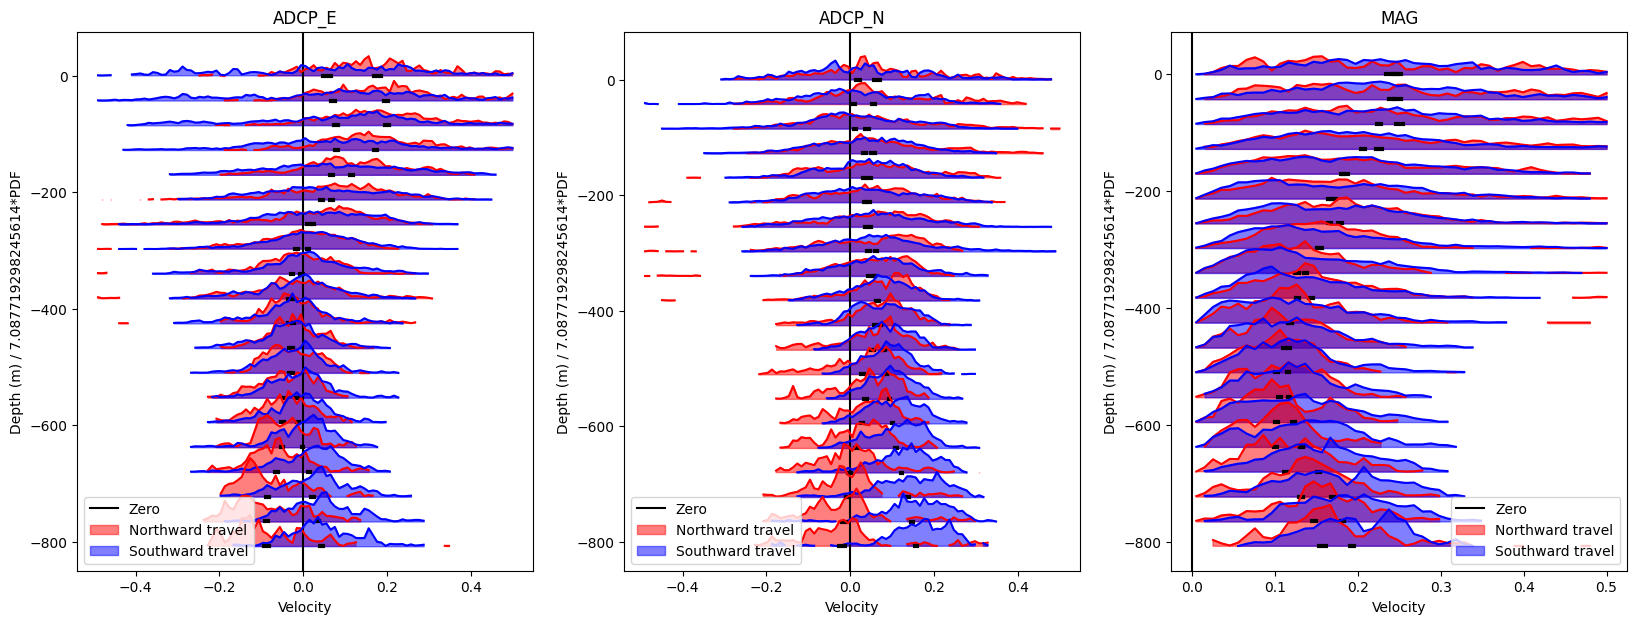

In [26]:
process_adcp.verify_depth_bias(out, yaxis, options)

### 2.7 Correct shear bias

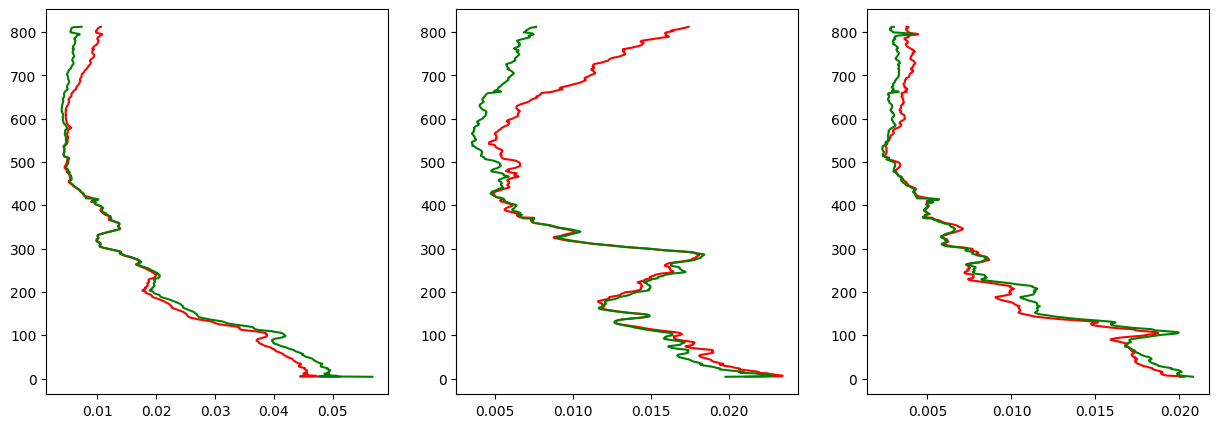

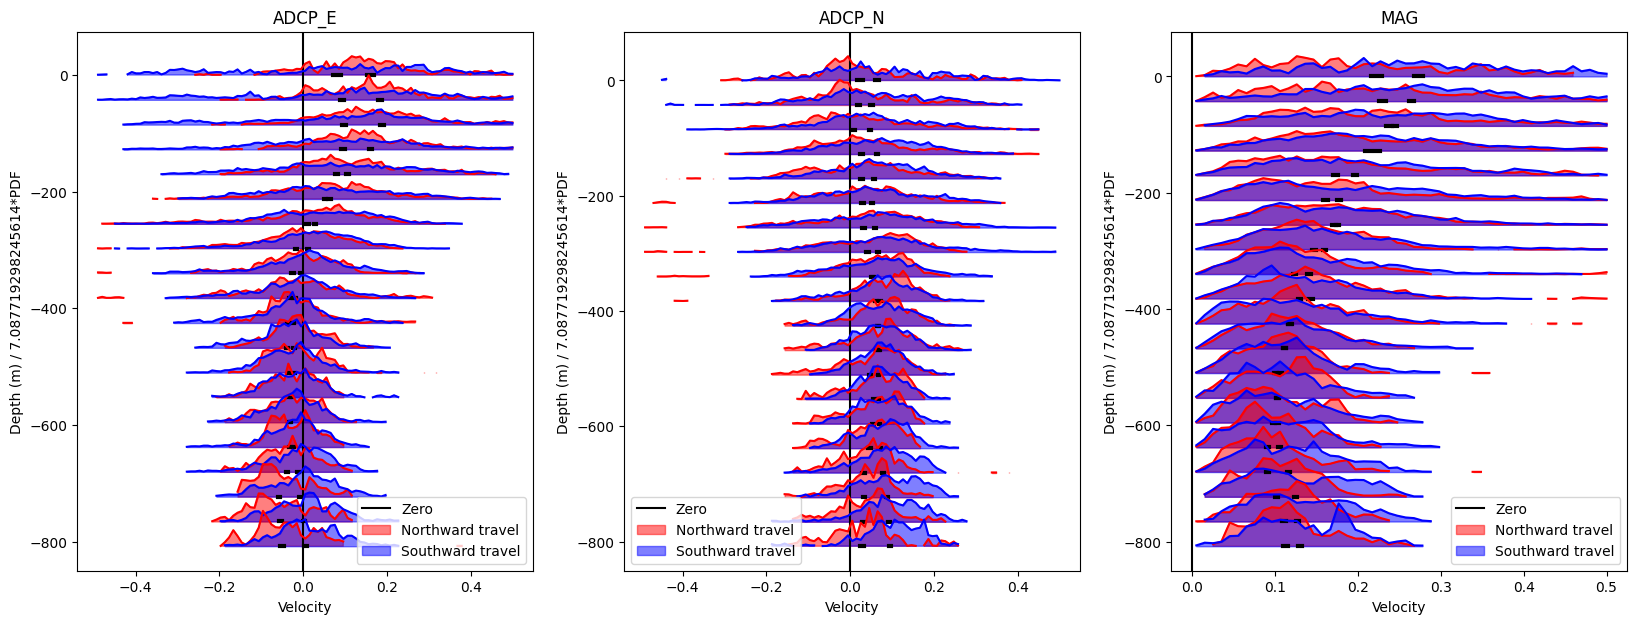

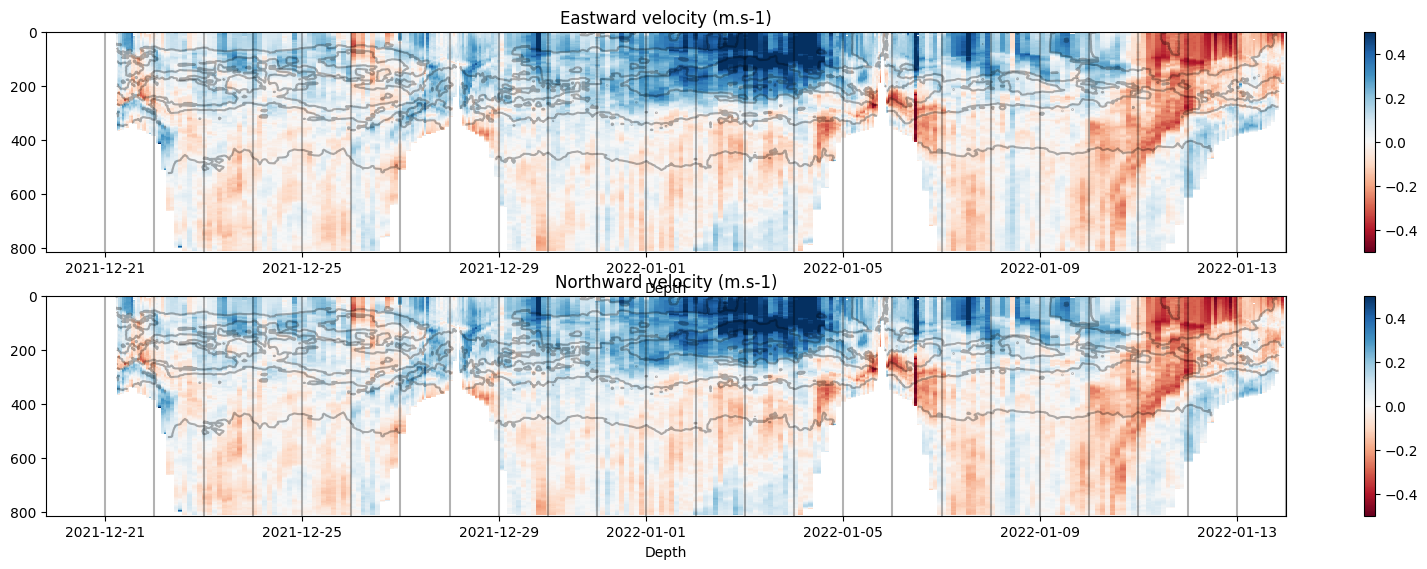

In [27]:
out = process_adcp.calc_bias(out, yaxis, taxis, days, options)

## 2.8 Create xarray DataSet from `out`

In [28]:
ds = process_adcp.make_dataset(out)
ds.to_netcdf("gridded_velocity.nc")

<xarray.Dataset>
Dimensions:           (depth_bin: 814, profile_num: 322)
Coordinates:
  * profile_num       (profile_num) int64 0 1 2 3 4 5 ... 317 318 319 320 321
  * depth_bin         (depth_bin) int64 0 1 2 3 4 5 ... 808 809 810 811 812 813
Data variables: (12/25)
    ADCP_E            (depth_bin, profile_num) float64 nan nan nan ... nan nan
    ADCP_N            (depth_bin, profile_num) float64 nan nan nan ... nan nan
    Sh_E              (depth_bin, profile_num) float64 nan nan nan ... nan nan
    Sh_N              (depth_bin, profile_num) float64 nan nan nan ... nan nan
    Sh_U              (depth_bin, profile_num) float64 nan nan nan ... nan nan
    Heading           (depth_bin, profile_num) float64 nan nan nan ... nan nan
    ...                ...
    dive_number       (depth_bin, profile_num) float64 nan nan nan ... nan nan
    speed_e           (depth_bin, profile_num) float64 nan nan nan ... nan nan
    speed_n           (depth_bin, profile_num) float64 nan nan nan ... nan nan
    DAC_E             (depth_bin, profile_num) float64 nan nan nan ... nan nan
    DAC_N             (depth_bin, profile_num) float64 nan nan nan ... nan nan
    profile_datetime  (profile_num) datetime64[ns] 2021-12-21T05:17:32.286280...